# Miniproject: Modelling the climate or the weather?

Is past performance an indicator of future weather?

## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe. 

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.


### Machine Learning Tasks: 
1. Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?  [Later in the term files containing the 2021 data will be made available
2. Can you design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) any better than assuming that the weather tomorrow will be exactly the same as the weather today

### Potential extensions
1. Can you train a machine learning technique to predict 10 or 20 years into the future?
2. Where will the hotest part of the world be in 20 years time?
3. What else can you study with this dataset? Is the sun in Utah a predictor of the rain in Spain? 
4. How close do weather stations need to be to provide reliable forecasts at other stations?

### Caveats
This is real data from weather stations around the world. This means that there are 'holes' in the data. You must be able to handle these 'holes' in some error tolerant fashion.


In [1]:
# import the urllib library
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt 
 
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]
        
    

#  Defined functions


I decided to place all the functions at the start of the notebook as I believe it makes the notebook clearer and easier to follow.

In [2]:
# extractdatavalues function extracts the data values for a given station

def extractdatavalues(stationnumber):
    '''Extracts the data values of the variables for a given station.
    The data values are produced as a 2D array with the number of
    rows being the number of data points and 2 columns; The first column are the dates
    and the second column are the values of the variable on that date'''
    whichStat=stationnumber
    fileName=statNames[whichStat]+'.dly'
    urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

    # So get the chosen station 

    # Copy a network object to a local file
    urllib.request.urlretrieve(urlName,fileName)
    statDict=ghn.processFile(fileName)
    
    # then obtain the stactDict variable as shown
    # then from statDict variable, can extract data 
    
    tmaxArray=ghn.getVar(statDict,'TMAX')
    #tmaxdays, tmax = zip(*tmaxArray)

    tminArray=ghn.getVar(statDict,'TMIN')
    #tmindays, tmin = zip(*tminArray)

    prcpArray=ghn.getVar(statDict,'PRCP')
    #prcpdays, prcp = zip(*prcpArray)

    snowArray=ghn.getVar(statDict,'SNOW')
    #snowdays, prcp = zip(*snowArray)
    
    snwdArray=ghn.getVar(statDict,'SNWD')
    #snwddays, prcp = zip(*snwdArray)
    
    return tmaxArray,tminArray,prcpArray,snowArray,snwdArray

# Function which plots the data for a given station and variable

def plotdata(dataarray,varname,units,stationnumber):
    '''Plots data for an input 2D data array'''
    x, y = zip(*dataarray)
    plt.figure()
    plt.plot(x,y, 'r.')
    plt.xlabel("date")
    plt.ylabel('{} ({})'.format(varname,units))
    plt.title('{} for station ID: {}'.format(varname,statNames[stationnumber]))
    
# Function which seperates the data into input and target data

def make_timeseqs(series,n_ts,offset):
    '''Function to convert a series with data values into a dataframe of n_ts values 
 with a target offset samples later'''
    nn_df = pd.DataFrame()
    # pd.datframe() literally creates the table
    for i in range(n_ts):
        nn_df[i] = series.shift(n_ts-i) #Shift the data by n_ts-i samples
    nn_df['label'] = series.shift(-offset)
    return nn_df

# Code adapted from 'Week6_pandas' by Ryan Nichols
    
# Function that tabulates data

def tabulate(Data,offset,n_ts):
    '''Function that takes weekly average of given data and tabulates it
    Input data is a 2D array with rows being the number of data points, the first column are the dates
    and the second column are the values of a given variable on that date.'''
    # Turn data into dataframe
    # Data is in 2D array: (days,variable value on corresponding date)
    df = pd.DataFrame(Data, columns=['Date','Variable'])
    # Compute weekly average of the given variable
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df1 = df.groupby(pd.Grouper(freq='W', key='Date'))['Variable'].mean()
    df1 = pd.DataFrame(df1,columns=['Variable'])
    nn_df=make_timeseqs(df1.Variable,n_ts,offset) 
    # Drop data which can't be used
    nn_df.dropna(axis=0, inplace=True)
    return nn_df

# Now define funciton to turn data into training data

def tableformtotrainingform(dataframe,testvalues):
    '''Function which transforms the tabulated data into a form
    which can be used as training data for the model'''
    train_label=dataframe.label.values 
    train_data=dataframe.drop('label',axis=1).values
    #df.drop removes the label comlumn
    
    #print(train_data.shape)
    train_data=train_data.reshape(-1,n_ts,1)
    #print(train_data.shape)
    #print(train_label.shape)
    
    test_data=train_data[-testvalues:]
    test_label=train_label[-testvalues:]
    # The last 'testvalues' amount of data
    train_data=train_data[:-testvalues]
    train_label=train_label[:-testvalues]
    # Up until the last 'testvalues' amount of data

    from sklearn.model_selection import train_test_split
    train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
    #print(train_data.shape)
    # (rows,n_ts,features)
    
    return train_data,train_label,val_data,val_label,test_data,test_label

# trainingcondition function is useful if unsure of number of data points in dataframe

def trainingcondition(dataframe,testvalues,dataframename):
    '''Determines whether data meets training condition and the data which does staisfy the condition
    is converted into training form'''
    if np.shape(dataframe)[0] < testvalues:
        return print(f'The dataframe of',dataframename,'does not have enough valid data for training')
    else:
        train_label=dataframe.label.values 
        train_data=dataframe.drop('label',axis=1).values
        #df.drop removes the label comlumn
    
        #print(train_data.shape)
        train_data=train_data.reshape(-1,n_ts,1)
        #print(train_data.shape)
        #print(train_label.shape)
    
        test_data=train_data[-testvalues:]
        test_label=train_label[-testvalues:]
        # The last 52
        train_data=train_data[:-testvalues]
        train_label=train_label[:-testvalues]
        # Up until the last 52

        from sklearn.model_selection import train_test_split
        train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
        #print(train_data.shape)
        # (rows,n_ts,features)
        
        return train_data,train_label,val_data,val_label,test_data,test_label
    
# tabulatelist function does the same thing as tabulate function but can do it for numerous
# data variables at once

def tabulatelist(Datalist,offset,n_ts):
    '''Function that takes weekly average of given data list and tabulates it'''
    nn_df_list = []
    arrayloop = np.arange(0,len(Datalist),1)
    for i in arrayloop:
        # Turn data into dataframe
        # Data is in 2D array: (days,variable value on corresponding date)
        df = pd.DataFrame(Datalist[i], columns=['Date','Variable'])
        # Compute weekly average of the given variable
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df1 = df.groupby(pd.Grouper(freq='W', key='Date'))['Variable'].mean()
        df1 = pd.DataFrame(df1,columns=['Variable'])
        nn_df=make_timeseqs(df1.Variable,n_ts,offset) 
        # Drop data which can't be used
        nn_df.dropna(axis=0, inplace=True)
        nn_df_list.append(nn_df)
    return nn_df_list

# trainingconditionlist function analyses whether a dataframe has enough datapoints to undergo
# training then carries out the training. Can do this for numerous dataframes at once.

def trainingconditionlist(dataframelist,testvalues,dataframenames,model,epochs,n,units):
    '''Determines whether data meets training condition 
    and the data which does staisfy the condition
    is converted into training form and then trained. 
    The results of the training and the model predictions 
    are also plotted.'''
    arrayloop = np.arange(0,len(dataframelist),1)
    for i in arrayloop: 
        if np.shape(dataframelist[i])[0] < testvalues:
            continue # just continue onto next iteration of loop
        else:
            print('{}'.format(dataframenames[i]))
            # Train
            train_data,train_label,val_data,val_label,test_data,test_label = tableformtotrainingform(dataframelist[i],testvalues)
            history=model.fit(train_data, train_label,epochs=epochs,batch_size= round( np.shape(train_data)[0]/n ),verbose=1,validation_data=(val_data,val_label))
            # Batchsize defined in this way to ensure it's a good number
            # Not too little not too large
            # Plot loss
            fig,ax=plt.subplots()
            ax.plot(history.history['loss'], label='train_loss')
            ax.plot(history.history['val_loss'], label='val_loss')
            plt.title("Loss of the model")
            plt.xlabel("Time (Epochs)")
            plt.ylabel("Loss")
            ax.legend()    
            # Plot predictions
            test_predict=model.predict(test_data)
            fig,ax=plt.subplots()
            ax.plot(test_predict,label="Predicted Data")
            ax.plot(test_label,label="True Test Data")
            ax.set_title("Prediction vs Reality")
            ax.set_xlabel("Sample #")
            ax.set_ylabel('{} ({})'.format(dataframenames[i],units[i]))
            ax.legend()
            


# Extracting and plotting data

Firstly, I tried to understand what was going on in the given code; it was found that each station has a corresponding dataset and the data for the different weather variables need to be extracted from the dataset which is done below. This first dataset was chosen randomly and is from station CA002400404, ARCTIC BAY CS, Canada. 

The different weather variables are as follows:
- PRCP = Precipitation (mm)
- SNOW = Snowfall (mm)
- SNWD = Snow depth (mm)
- TMAX = Maximum temperature (degrees C)
- TMIN = Minimum temperature (degrees C)

The data is also plotted in its graphical form as it may provide additional insight.

In [3]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [4]:
# Get list of station names
statNames=ghn.getStatKeyNames()
print(ghn.getStation(statNames[220]))

CA002400404 is ARCTIC BAY CS, Canada at 73.0, -85.0167, 10.0


In [5]:
# Extract data values

# Station number 220 randomly chosen
tmaxArray,tminArray,prcpArray,snowArray,snwdArray = extractdatavalues(220)

# Analyse datavalues
print(np.shape(tmaxArray))
print(np.shape(tminArray))
print(np.shape(prcpArray))
print(np.shape(snowArray))
print(np.shape(snwdArray))

# Notice how there's different amounts of data for each variable, tmin, tmax etc
# i.e. different number of holes 

(5341, 2)
(5428, 2)
(3378, 2)
(760, 2)
(2255, 2)


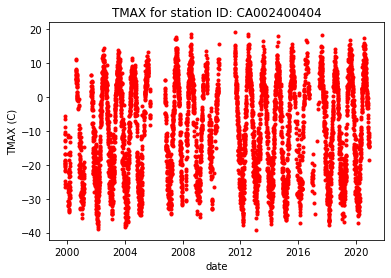

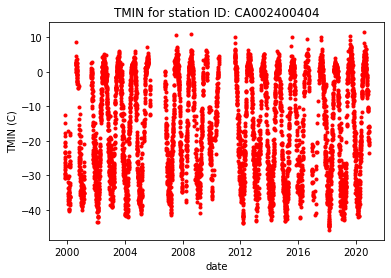

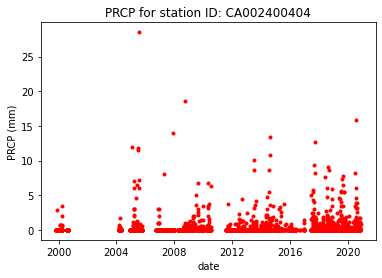

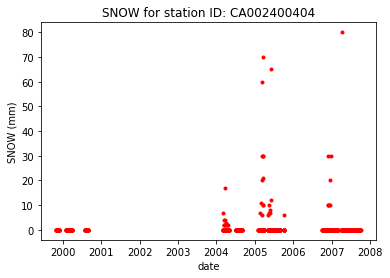

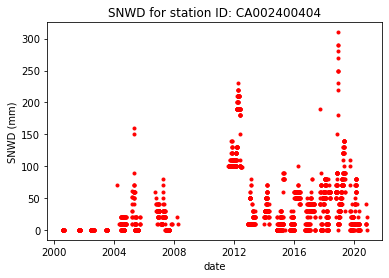

In [6]:
# plotting data for station 220

plotdata(tmaxArray,'TMAX','C',220)
plotdata(tminArray,'TMIN','C',220)
plotdata(prcpArray,'PRCP','mm',220)
plotdata(snowArray,'SNOW','mm',220)
plotdata(snwdArray,'SNWD','mm',220)

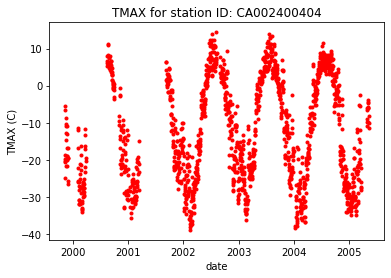

In [7]:
# More 'zoomed in' image of TMAX data
plotdata(tmaxArray[:1500],'TMAX','C',220)

# Machine learning task 2

### Can you design a machine learning technique that can predict the weather any better than assuming that the weather tomorrow will be exactly the same as the weather today.

The motivation for this part of the notebook was to achieve some sort of result. The result was later identified to be what was required in machine learning task 2.

The main point of refrence for this task was the 'Week_6 pandas' notebook by Ryan Nichols [1].  In this notebook, it demonstrates how to make future predictions on tabular data; this was the motivation behind using this notebook as the main point of reference. The weather data we're dealing with is essentially tabular data and the question we're trying to address is if past weather is an indicator of future weather, hence why I used it as a point of reference for the task. 

Nevertheless, the procedure below follows the same procedure as in the 'Week6_pandas' notebook. Intially, I had to convert the extracted data into a dataframe. After the data is in dataframe format, it can be prepared in a form ready for training; this consists of data in a sequence of length $n_{ts}$, which is the input to the model, and some data value which is an $offset$ away, which is the target of the model. For this task, the input data was data values of TMAX on 7 seperate days, and the target data was the data value of TMAX on the next recorded day. After the data had been prepared for training, the model was trained and predictions on future TMAX were made with the model. These predictions were then compared to the true data to analyse the quality of the model.

In summary, the TMAX data was prepared so that a model was trained to make next day TMAX predictions and the quality of the model is judged on the similarity of these predictions to the true data. The data is from the station CA002400404, ARCTIC BAY CS, Canada.

**Note**: I could've just used the functions I had already defined above however I believe it is beneficial to illustrate the step by step procedure, hence why I kept the initial step by step process I had to go through to complete the task.

In [8]:
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Import tqdm for progress bar
from tqdm import tqdm

#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Pandas
import pandas as pd

In [9]:
# Tabulating data

df = pd.DataFrame(tmaxArray, columns=['Date','Tmax'])
df.head()

# Idea of getting the tmaxArray into this tabulated form adapted from
# https://www.codegrepper.com/code-examples/python/numpy+2d+array+to+pandas+data+frame 
# [2]

# knowing how to adapt and get desired form come from link below
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
# [3]

Date  Tmax
0  1999-11-06 -18.6
1  1999-11-07 -20.5
2  1999-11-08 -20.3
3  1999-11-09 -24.8
4  1999-11-10 -19.8

In [10]:
# df.Tmax

In [11]:
# Seperating data into input and target data

offset=0
n_ts=7 #Number of values in a time sequence
nn_df=make_timeseqs(df.Tmax,n_ts,offset) #7 samples per row for training, offset of 0 (so next sample is target)
nn_df.head()


0   1   2     3     4     5     6  label
0 NaN NaN NaN   NaN   NaN   NaN   NaN  -18.6
1 NaN NaN NaN   NaN   NaN   NaN -18.6  -20.5
2 NaN NaN NaN   NaN   NaN -18.6 -20.5  -20.3
3 NaN NaN NaN   NaN -18.6 -20.5 -20.3  -24.8
4 NaN NaN NaN -18.6 -20.5 -20.3 -24.8  -19.8

In [12]:
# Get's rid of NaN's

nn_df.dropna(axis=0, inplace=True)
nn_df.head()

0     1     2     3     4     5     6  label
7  -18.6 -20.5 -20.3 -24.8 -19.8  -6.6  -5.6  -10.4
8  -20.5 -20.3 -24.8 -19.8  -6.6  -5.6 -10.4  -14.7
9  -20.3 -24.8 -19.8  -6.6  -5.6 -10.4 -14.7  -21.8
10 -24.8 -19.8  -6.6  -5.6 -10.4 -14.7 -21.8   -8.7
11 -19.8  -6.6  -5.6 -10.4 -14.7 -21.8  -8.7  -10.8

In [13]:
# Preparing training data

train_label=nn_df.label.values 
train_data=nn_df.drop('label',axis=1).values
#df.drop removes the label comlumn
print(train_data.shape)
train_data=train_data.reshape(-1,n_ts,1)
print(train_data.shape)
print(train_label.shape)

(5334, 7)
(5334, 7, 1)
(5334,)


In [14]:
# Preparing training,test and validation data

test_data=train_data[-100:]
test_label=train_label[-100:]
# The last 100
train_data=train_data[:-100]
train_label=train_label[:-100]
# Up until the last 100

from sklearn.model_selection import train_test_split
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape)
# (rows,n_ts,features)

(3925, 7, 1)


In [15]:
# Define model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(64,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model.add(keras.layers.LSTM(32, activation='relu'))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dense(1,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,457
Trainable params: 31,457
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Training

history=model.fit(train_data,train_label,epochs=10,batch_size=64,verbose=1,validation_data=(val_data,val_label))

Epoch 1/10
62/62 [==============================] - 4s 20ms/step - loss: 111.4929 - val_loss: 24.2400
Epoch 2/10
62/62 [==============================] - 1s 10ms/step - loss: 20.4490 - val_loss: 17.3556
Epoch 3/10
62/62 [==============================] - 1s 14ms/step - loss: 14.0151 - val_loss: 18.9488
Epoch 4/10
62/62 [==============================] - 1s 22ms/step - loss: 12.4561 - val_loss: 14.1692
Epoch 5/10
62/62 [==============================] - 1s 22ms/step - loss: 12.3069 - val_loss: 14.1966
Epoch 6/10
62/62 [==============================] - 1s 22ms/step - loss: 11.8020 - val_loss: 13.0912
Epoch 7/10
62/62 [==============================] - 1s 23ms/step - loss: 11.2424 - val_loss: 12.8416
Epoch 8/10
62/62 [==============================] - 1s 12ms/step - loss: 11.2406 - val_loss: 14.6521
Epoch 9/10
62/62 [==============================] - 1s 10ms/step - loss: 11.2169 - val_loss: 13.1384
Epoch 10/10
62/62 [==============================] - 1s 11ms/step - loss: 11.1422 - val_lo

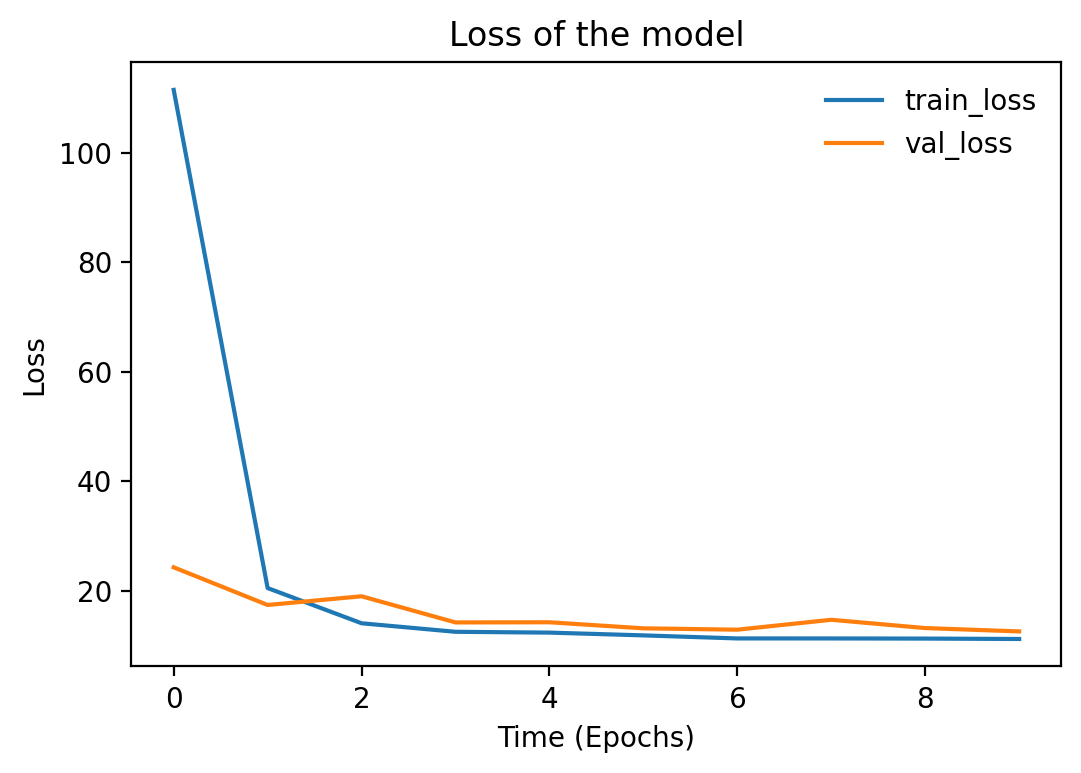

In [17]:
# Plotting loss

fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss of the model")
plt.xlabel("Time (Epochs)")
plt.ylabel("Loss")
ax.legend()

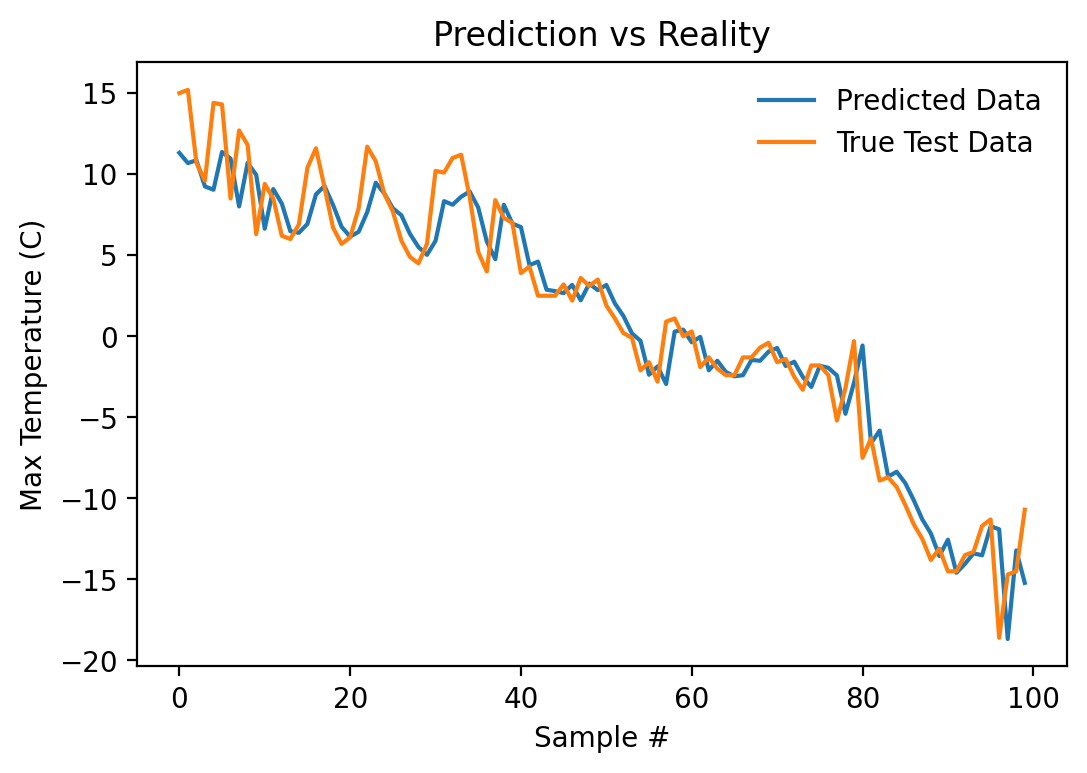

In [18]:
# Plotting prediction

test_predict=model.predict(test_data)
fig,ax=plt.subplots()
ax.plot(test_predict,label="Predicted Data")
ax.plot(test_label,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample #")
ax.set_ylabel("Max Temperature (C)")
ax.legend()


# Analysis

There are two things we can use to judge the quality of the model; the loss and the graphical comparison of the predicted and true data. 

This loss metric is what the model is trying to minimise during training. The value of the loss is dependent on the loss function defined in the model, here we used mean squared error which calculates the loss as $ loss = (y_{true} - y_{pred})^2 $, where $y_{true}$ is the value of the true data and $y_{pred}$ is the value of the predicted data. Therefore, the loss value depends on the actual value of the data, hence, even for predictions not far off from the true data, the loss can still be large for data that has high values. Therefore, the graphical comparisons would be a better judgement on the quality of the model.

We can see from the graph that the model predictions are of good quality; the model predicts the general trend of the data and picks up all of the fluctuations in the data as well. However, the predicted and true fluctuations differ in amplitude slightly and the timing of the predictions also differs to the true data

One problem with this approach was that we do not know if the model was trained to predict the next day TMAX. The data has 'holes' in it, in other words the station may not have data for TMAX on a given day. Therefore, when training the data, the input data and target data may not necessarily be 7 **consecutive** days and the **following day**, respectively. For instance the station can record data for Monday to Saturday, then the next record is the following Monday and Thursday. In this scenario, the input data would be the Monday-Saturday and the following Monday and the offset data would be the following Thursday data. 

Therefore, we can not exactly say that the model is trained over a weeks worth of TMAX data to predict the TMAX of the following day; a more accurate statement of what was done is that the model has been trained over 7 days of TMAX data to predict the TMAX of some day in the future.

# Machine learning task 1

###  Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?

The motivation for this section of the notebook was the observation made from the results of training a model, on daily data, to predict TMAX a year in advanced. These observations were made by changing the offset to 364 above, making the target of the model 364 samples after the last sample in the input sequence, therefore in an ideal dataset with no holes, the model is being trained to predict TMAX a year in advanced (365 days in a year). We observe that the predictions of the model are of poor quality; I believe this is because the daily data is noisy, which we can see from the plots of the data above, hence making it difficult to train the model to pick up the patterns in the data and hence leading to poor predictions.

Therefore, in this section, I decided to take weekly averages of the data and train the model on these weekly averages as the weekly averages should fluctuate less than the daily data and therefore lead to better training and predictions. The results were then later identified to be what was asked for in machine learning task 1.

Initially, I took weekly averages of the TMAX data then trained a model with this data to predict TMAX a year in advance (offset=51 as there are 52 weeks in a year). Then I took weekly averages of all the other variables and trained the same model over the other variables to make predictions of the other variables a year in advance. 

Repeating this weekly averaging, training and predicting become very tedious which was the motivation for creating the functions which average, tabulate and train the data automatically. Initially, I just created functions which takes the weekly average and tabulates the data for 1 variable, then a function which prepares the tabulated data for training then manually trained the model and plotted the results. This also became tedious as this had to be repeated for all the weather variables, therefore I created the tabulatelist and trainingconiditionlist functions which can carry out the averaging,training and predicting for all the variables at once. 

I kept the hard code of the averaging,training and predicting for TMAX to illustrate the step by step procedure of what was done however I decided to just show the functions being used for the remaining variables to improve the readibility of the notebook.

In [19]:
df.head(9)

Date  Tmax
0  1999-11-06 -18.6
1  1999-11-07 -20.5
2  1999-11-08 -20.3
3  1999-11-09 -24.8
4  1999-11-10 -19.8
5  1999-11-11  -6.6
6  1999-11-12  -5.6
7  1999-11-13 -10.4
8  1999-11-14 -14.7

In [20]:
# Take weekly average of data

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df.head()

df1 = df.groupby(pd.Grouper(freq='W', key='Date'))['Tmax'].mean()

df1.head(20)
#print(len(df1))

# Code adapted from 
# https://stackoverflow.com/questions/48272540/pandas-typeerror-only-valid-with-datetimeindex-timedeltaindex-or-periodindex
# [6]

# okay so we see below - the very first data point we have 
# is on a saturday - the datetime code notes this

# after the groupby code:

# the very first piece of data then is the average of the saturday (6th) and sunday (7th) weather
# then the '1999-11-14' is the average from the Monday (8th) to the Sunday (14th) weather
# and so on.

# Can also see for the data with the holes in them, we dont have average values for these weeks
# which is what we want

Date
1999-11-07   -19.550000
1999-11-14   -14.600000
1999-11-21   -13.514286
1999-11-28   -21.600000
1999-12-05   -18.100000
1999-12-12          NaN
1999-12-19          NaN
1999-12-26          NaN
2000-01-02          NaN
2000-01-09          NaN
2000-01-16          NaN
2000-01-23          NaN
2000-01-30          NaN
2000-02-06   -18.950000
2000-02-13   -29.500000
2000-02-20   -25.285714
2000-02-27   -25.400000
2000-03-05   -31.185714
2000-03-12   -27.657143
2000-03-19   -26.228571
Freq: W-SUN, Name: Tmax, dtype: float64

In [21]:
# Convert back to dataframe so make time seqs func can be used

df1 = pd.DataFrame(df1,columns=['Tmax'])
df1.head(9)

Tmax
Date                 
1999-11-07 -19.550000
1999-11-14 -14.600000
1999-11-21 -13.514286
1999-11-28 -21.600000
1999-12-05 -18.100000
1999-12-12        NaN
1999-12-19        NaN
1999-12-26        NaN
2000-01-02        NaN

In [22]:
# Seperating data into input and target data

offset=51 # 52 weeks ~ 1 year ( want to predict a year in advace)
n_ts=8 #Number of values in a time sequence (8 weeks ~2 month)
nn_df=make_timeseqs(df1.Tmax,n_ts,offset) 
nn_df.head(25)

# Note - model performs better as we increase n_ts - as we'd expect
# as we're essentially showing the model more data 

0          1          2          3          4          5  \
Date                                                                           
1999-11-07        NaN        NaN        NaN        NaN        NaN        NaN   
1999-11-14        NaN        NaN        NaN        NaN        NaN        NaN   
1999-11-21        NaN        NaN        NaN        NaN        NaN        NaN   
1999-11-28        NaN        NaN        NaN        NaN        NaN -19.550000   
1999-12-05        NaN        NaN        NaN        NaN -19.550000 -14.600000   
1999-12-12        NaN        NaN        NaN -19.550000 -14.600000 -13.514286   
1999-12-19        NaN        NaN -19.550000 -14.600000 -13.514286 -21.600000   
1999-12-26        NaN -19.550000 -14.600000 -13.514286 -21.600000 -18.100000   
2000-01-02 -19.550000 -14.600000 -13.514286 -21.600000 -18.100000        NaN   
2000-01-09 -14.600000 -13.514286 -21.600000 -18.100000        NaN        NaN   
2000-01-16 -13.514286 -21.600000 -18.100000        NaN        NaN        NaN   
2000-01-23 -21.600000 -18.100000        NaN        NaN        NaN        NaN   
2000-01-30 -18.100000        NaN        NaN        NaN        NaN        NaN   
2000-02-06        NaN        NaN        NaN        NaN        NaN        NaN   
2000-02-13        NaN        NaN        NaN        NaN        NaN        NaN   
2000-02-20        NaN        NaN        NaN        NaN        NaN        NaN   
2000-02-27        NaN        NaN        NaN        NaN        NaN -18.950000   
2000-03-05        NaN        NaN        NaN        NaN -18.950000 -29.500000   
2000-03-12        NaN        NaN        NaN -18.950000 -29.500000 -25.285714   
2000-03-19        NaN        NaN -18.950000 -29.500000 -25.285714 -25.400000   
2000-03-26        NaN -18.950000 -29.500000 -25.285714 -25.400000 -31.185714   
2000-04-02 -18.950000 -29.500000 -25.285714 -25.400000 -31.185714 -27.657143   
2000-04-09 -29.500000 -25.285714 -25.400000 -31.185714 -27.657143 -26.228571   
2000-04-16 -25.285714 -25.400000 -31.185714 -27.657143 -26.228571 -16.400000   
2000-04-23 -25.400000 -31.185714 -27.657143 -26.228571 -16.400000        NaN   

                    6          7      label  
Date                                         
1999-11-07        NaN        NaN        NaN  
1999-11-14        NaN -19.550000  -6.320000  
1999-11-21 -19.550000 -14.600000 -14.542857  
1999-11-28 -14.600000 -13.514286 -19.871429  
1999-12-05 -13.514286 -21.600000 -16.814286  
1999-12-12 -21.600000 -18.100000 -21.085714  
1999-12-19 -18.100000        NaN -19.400000  
1999-12-26        NaN        NaN -22.800000  
2000-01-02        NaN        NaN -27.200000  
2000-01-09        NaN        NaN -23.042857  
2000-01-16        NaN        NaN -13.300000  
2000-01-23        NaN        NaN -29.500000  
2000-01-30        NaN        NaN -33.533333  
2000-02-06        NaN        NaN -28.480000  
2000-02-13        NaN -18.950000 -27.733333  
2000-02-20 -18.950000 -29.500000 -27.114286  
2000-02-27 -29.500000 -25.285714 -30.685714  
2000-03-05 -25.285714 -25.400000 -26.685714  
2000-03-12 -25.400000 -31.185714 -24.816667  
2000-03-19 -31.185714 -27.657143 -21.800000  
2000-03-26 -27.657143 -26.228571 -21.300000  
2000-04-02 -26.228571 -16.400000        NaN  
2000-04-09 -16.400000        NaN        NaN  
2000-04-16        NaN        NaN        NaN  
2000-04-23        NaN        NaN        NaN

In [23]:
# remove NaN's

nn_df.dropna(axis=0, inplace=True)
nn_df.head(9)

# So now we only keep data which do not have holes for 8 consecutive weeks
# and does not have a hole 52 weeks after the 8th week in the sequence.
# Therefore we are assured that we are actually training the model to predict 
# 1 year in advanced and do not face the problem we did in section 1.

# Now with the data in form how we would like
# can do normal training method.

0          1          2          3          4          5  \
Date                                                                           
2000-10-08   6.350000   7.780000   7.340000   5.683333   5.528571   3.371429   
2000-12-31  -6.320000 -14.542857 -19.871429 -16.814286 -21.085714 -19.400000   
2001-01-07 -14.542857 -19.871429 -16.814286 -21.085714 -19.400000 -22.800000   
2001-01-14 -19.871429 -16.814286 -21.085714 -19.400000 -22.800000 -27.200000   
2001-01-21 -16.814286 -21.085714 -19.400000 -22.800000 -27.200000 -23.042857   
2001-01-28 -21.085714 -19.400000 -22.800000 -27.200000 -23.042857 -13.300000   
2001-02-04 -19.400000 -22.800000 -27.200000 -23.042857 -13.300000 -29.500000   
2001-02-11 -22.800000 -27.200000 -23.042857 -13.300000 -29.500000 -33.533333   
2001-02-18 -27.200000 -23.042857 -13.300000 -29.500000 -33.533333 -28.480000   

                    6          7      label  
Date                                         
2000-10-08   0.200000  -1.250000   2.914286  
2000-12-31 -22.800000 -27.200000 -14.666667  
2001-01-07 -27.200000 -23.042857 -14.633333  
2001-01-14 -23.042857 -13.300000 -21.828571  
2001-01-21 -13.300000 -29.500000 -30.185714  
2001-01-28 -29.500000 -33.533333 -30.242857  
2001-02-04 -33.533333 -28.480000 -22.128571  
2001-02-11 -28.480000 -27.733333 -27.485714  
2001-02-18 -27.733333 -27.114286 -25.342857

In [24]:
#print(len(nn_df.label))

In [25]:
# Pepare training data

train_label=nn_df.label.values 
train_data=nn_df.drop('label',axis=1).values
#df.drop removes the label comlumn
print(train_data.shape)
train_data=train_data.reshape(-1,n_ts,1)
print(train_data.shape)
print(train_label.shape)


(565, 8)
(565, 8, 1)
(565,)


In [26]:
# Preparing training,test and validation data

test_data=train_data[-52:]
test_label=train_label[-52:]
# The last 52
train_data=train_data[:-52]
train_label=train_label[:-52]
# Up until the last 52

from sklearn.model_selection import train_test_split
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape)
# (rows,n_ts,features)

(384, 8, 1)


In [27]:
# Define model
model1=keras.models.Sequential()
model1.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model1.add(keras.layers.LSTM(50, activation='relu'))
model1.add(keras.layers.Dense(50,activation='relu'))
model1.add(keras.layers.Dense(50,activation='relu'))
model1.add(keras.layers.Dense(50,activation='relu'))
model1.add(keras.layers.Dense(1,activation="linear"))
model1.compile(loss='mean_squared_error',optimizer='adam')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8, 100)            40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-trai

In [28]:
# Training

history1=model1.fit(train_data,train_label,epochs=15,batch_size=100,verbose=1,validation_data=(val_data,val_label))

# Note - model does not always perform better as batch_size is increase - tried
# it with =300 and consistently performed significantly worse than at 100

Epoch 1/15
4/4 [==============================] - 3s 224ms/step - loss: 278.2982 - val_loss: 256.4518
Epoch 2/15
4/4 [==============================] - 0s 26ms/step - loss: 268.0523 - val_loss: 241.6029
Epoch 3/15
4/4 [==============================] - 0s 26ms/step - loss: 246.0856 - val_loss: 207.2891
Epoch 4/15
4/4 [==============================] - 0s 27ms/step - loss: 194.2823 - val_loss: 134.0958
Epoch 5/15
4/4 [==============================] - 0s 27ms/step - loss: 108.8939 - val_loss: 96.3444
Epoch 6/15
4/4 [==============================] - 0s 28ms/step - loss: 95.8551 - val_loss: 66.5150
Epoch 7/15
4/4 [==============================] - 0s 28ms/step - loss: 68.9755 - val_loss: 61.3411
Epoch 8/15
4/4 [==============================] - 0s 28ms/step - loss: 60.5933 - val_loss: 41.5412
Epoch 9/15
4/4 [==============================] - 0s 28ms/step - loss: 41.9483 - val_loss: 25.8030
Epoch 10/15
4/4 [==============================] - 0s 27ms/step - loss: 31.8646 - val_loss: 22.3944

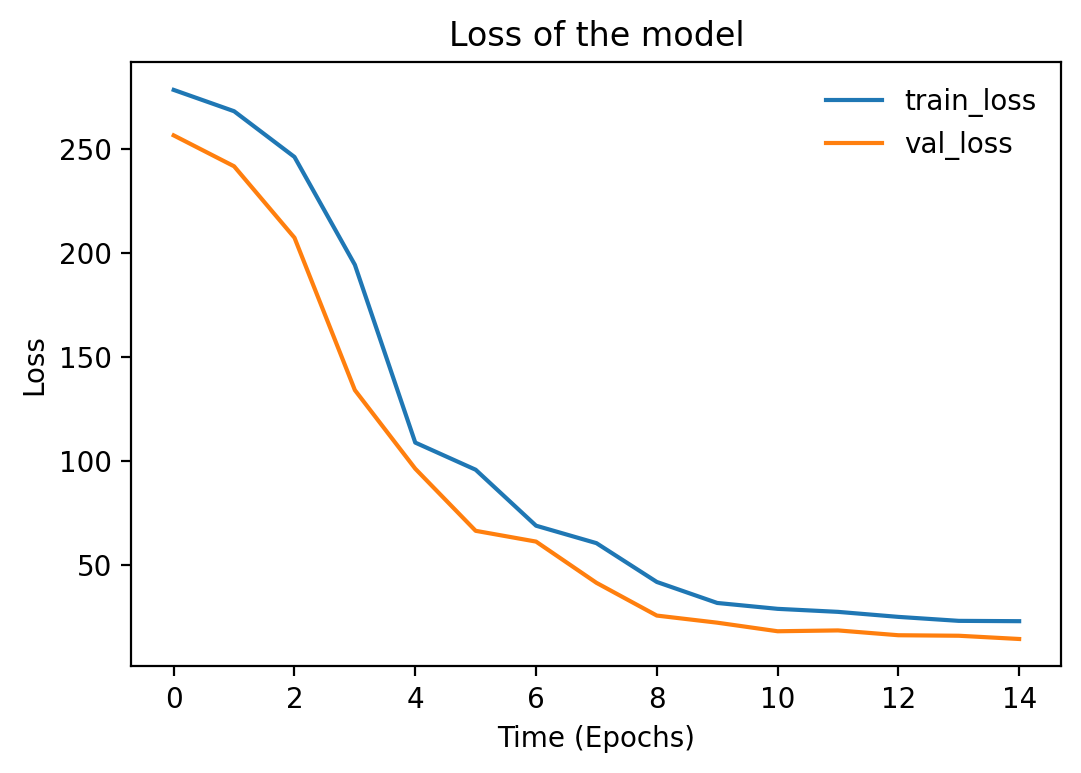

In [29]:
# Plot loss

fig,ax=plt.subplots()
ax.plot(history1.history['loss'], label='train_loss')
ax.plot(history1.history['val_loss'], label='val_loss')
plt.title("Loss of the model")
plt.xlabel("Time (Epochs)")
plt.ylabel("Loss")
ax.legend()

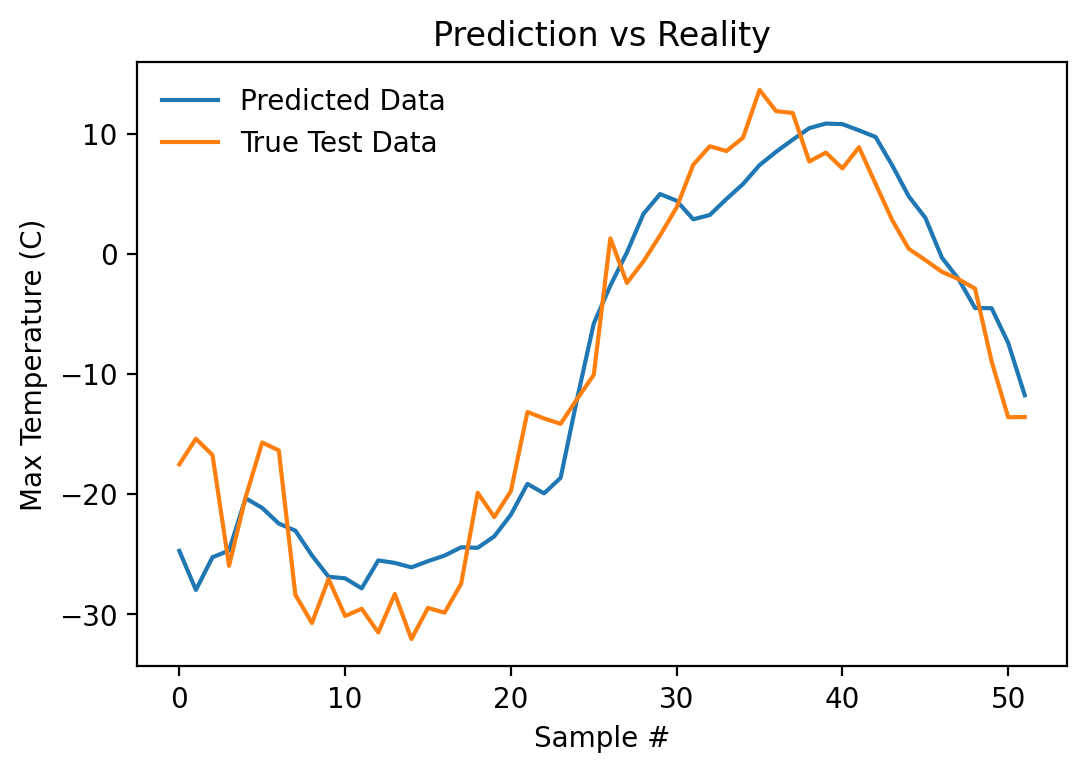

In [30]:
# Plot predictions

test_predict=model1.predict(test_data)
fig,ax=plt.subplots()
ax.plot(test_predict,label="Predicted Data")
ax.plot(test_label,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample #")
ax.set_ylabel("Max Temperature (C)")
ax.legend()


### Training all the variables at once

In [31]:
# Tabulate data

Datalisttest = [tmaxArray,tminArray,prcpArray,snowArray,snwdArray]
offset = 51
n_ts = 8
tabulatelisttest = tabulatelist(Datalisttest,offset,n_ts)

TMAX
Epoch 1/20
4/4 [==============================] - 2s 35ms/step - loss: 21.1231 - val_loss: 14.5284
Epoch 2/20
4/4 [==============================] - 0s 26ms/step - loss: 22.1251 - val_loss: 15.3740
Epoch 3/20
4/4 [==============================] - 0s 26ms/step - loss: 21.0960 - val_loss: 14.9444
Epoch 4/20
4/4 [==============================] - 0s 28ms/step - loss: 20.6440 - val_loss: 15.0726
Epoch 5/20
4/4 [==============================] - 0s 42ms/step - loss: 22.5920 - val_loss: 14.9073
Epoch 6/20
4/4 [==============================] - 0s 40ms/step - loss: 20.8780 - val_loss: 13.8301
Epoch 7/20
4/4 [==============================] - 0s 40ms/step - loss: 20.2600 - val_loss: 14.1688
Epoch 8/20
4/4 [==============================] - 0s 41ms/step - loss: 19.6203 - val_loss: 14.3048
Epoch 9/20
4/4 [==============================] - 0s 41ms/step - loss: 19.5800 - val_loss: 14.0168
Epoch 10/20
4/4 [==============================] - 0s 39ms/step - loss: 19.2461 - val_loss: 14.3346
Epoc

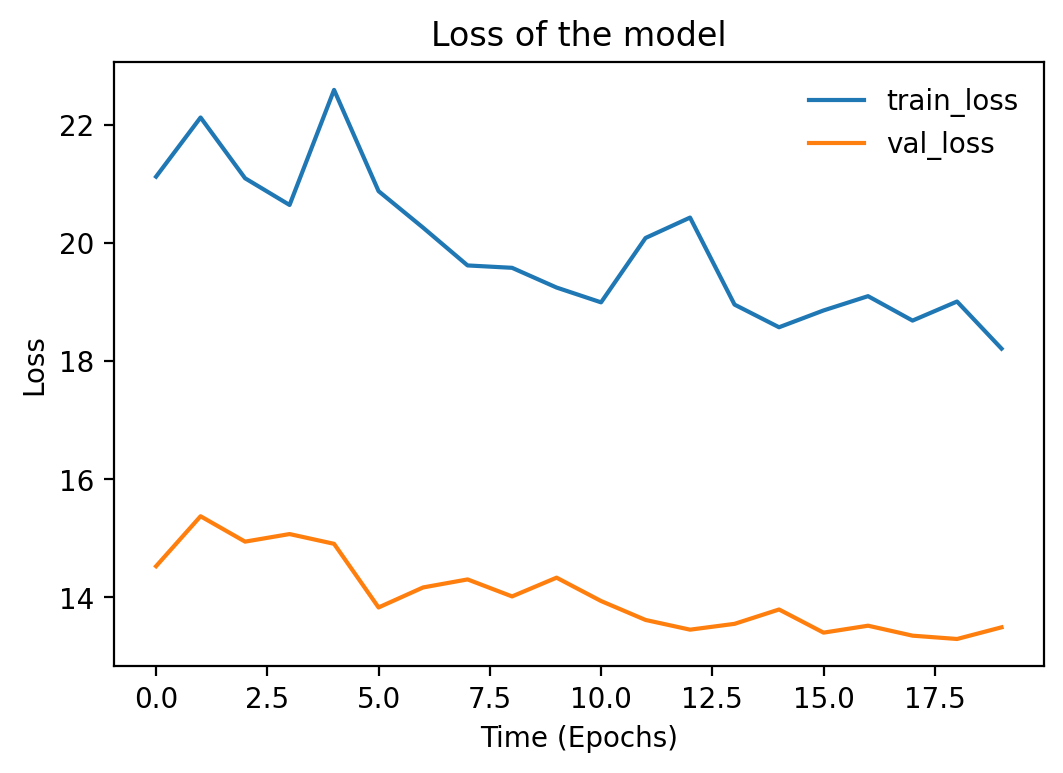

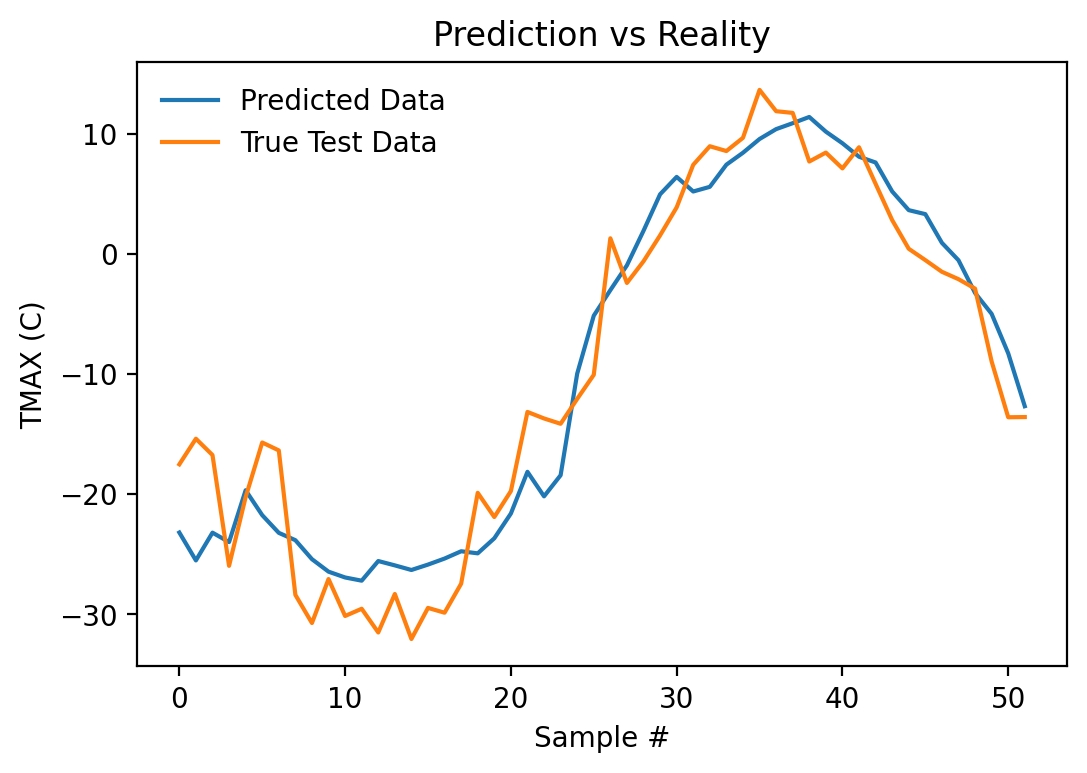

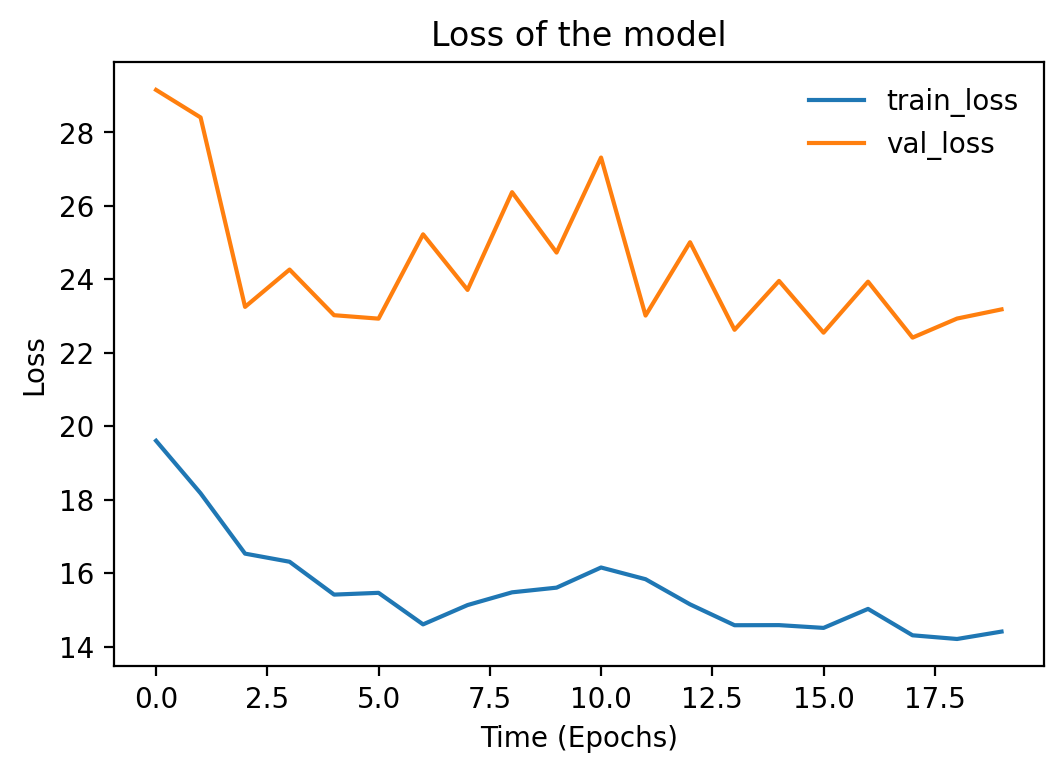

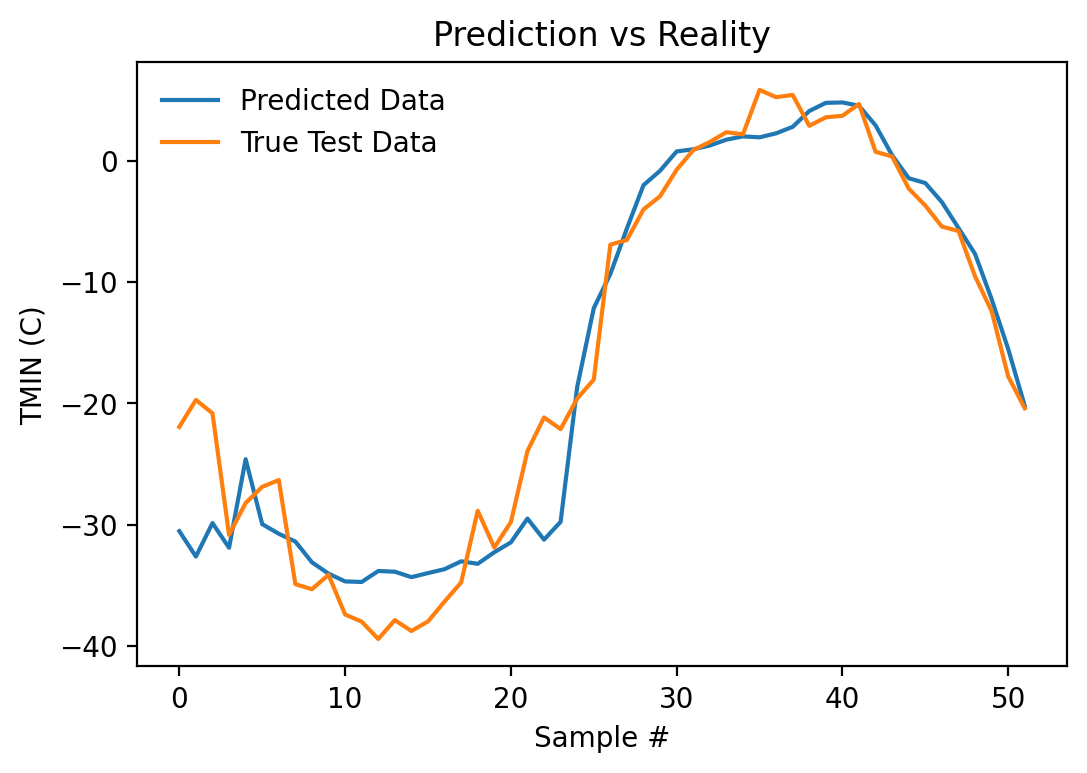

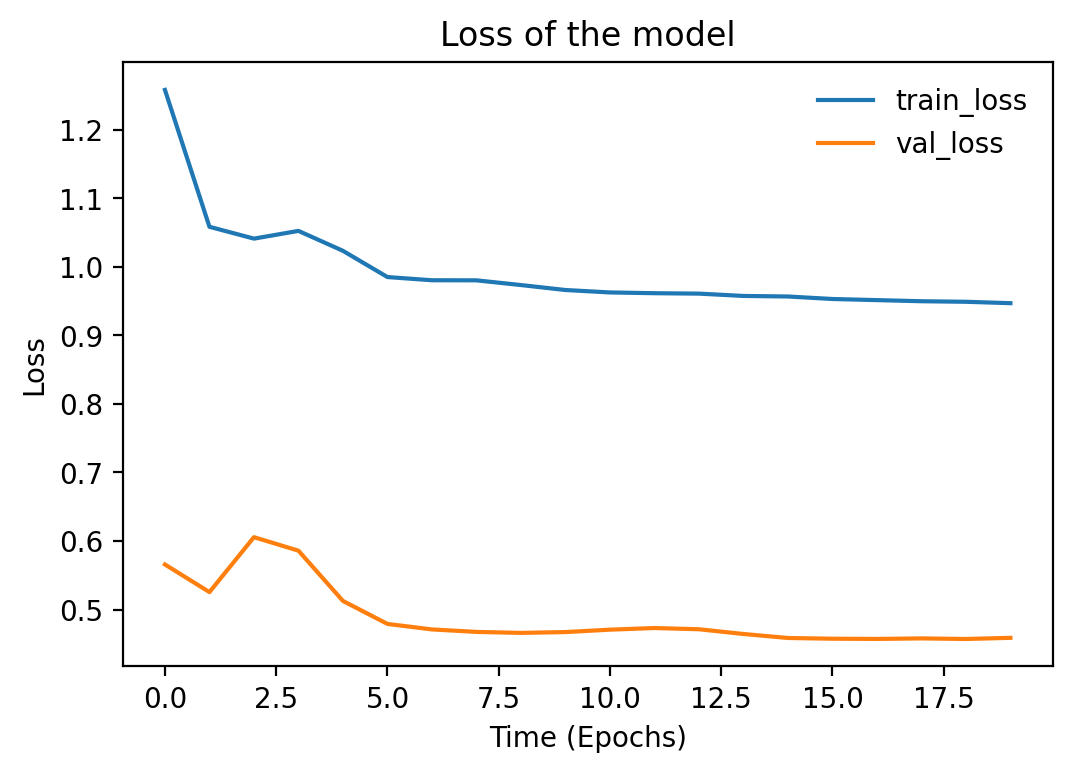

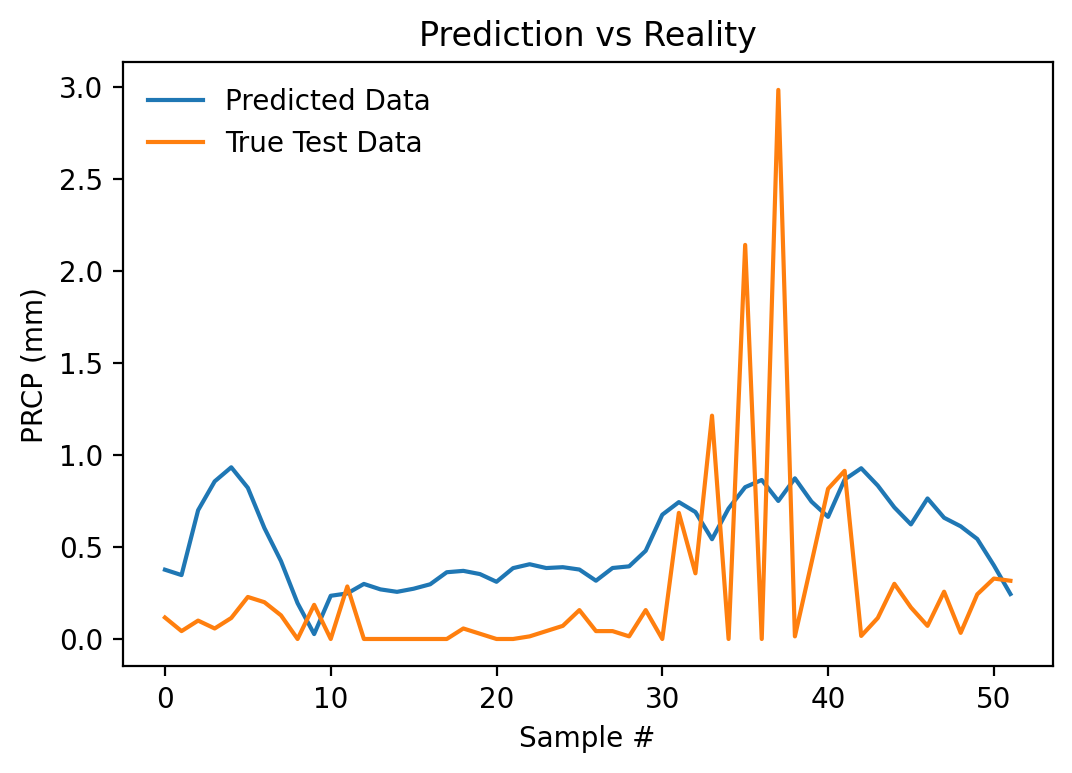

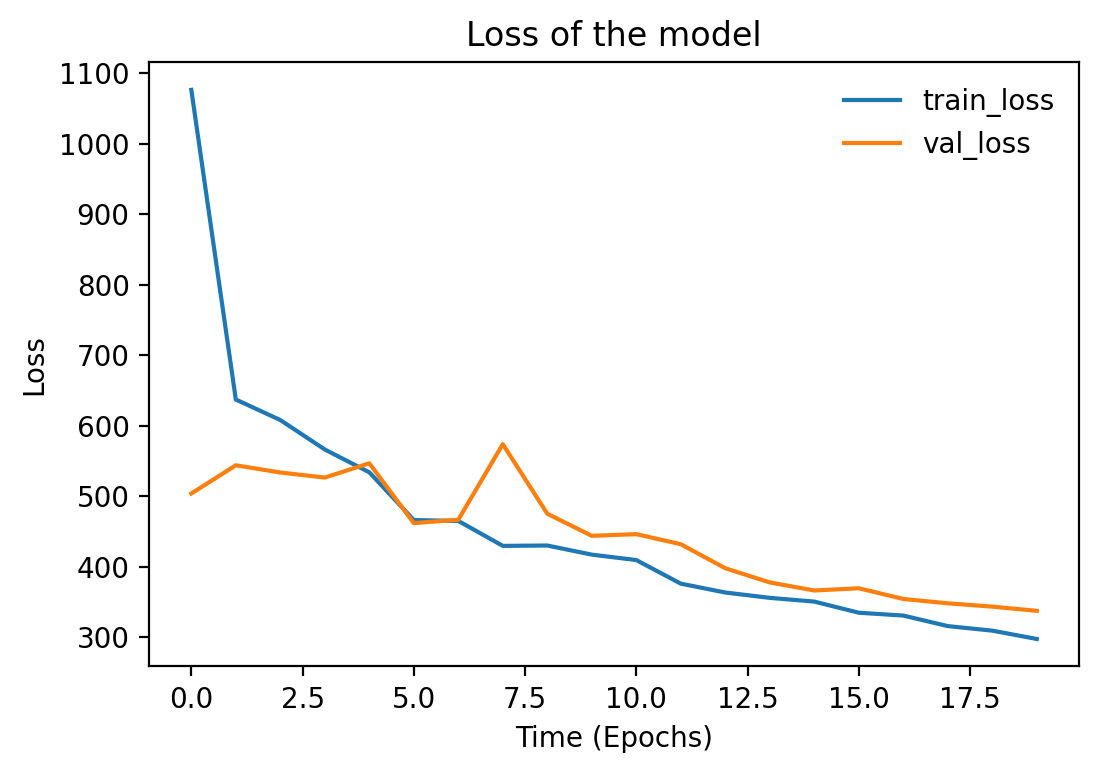

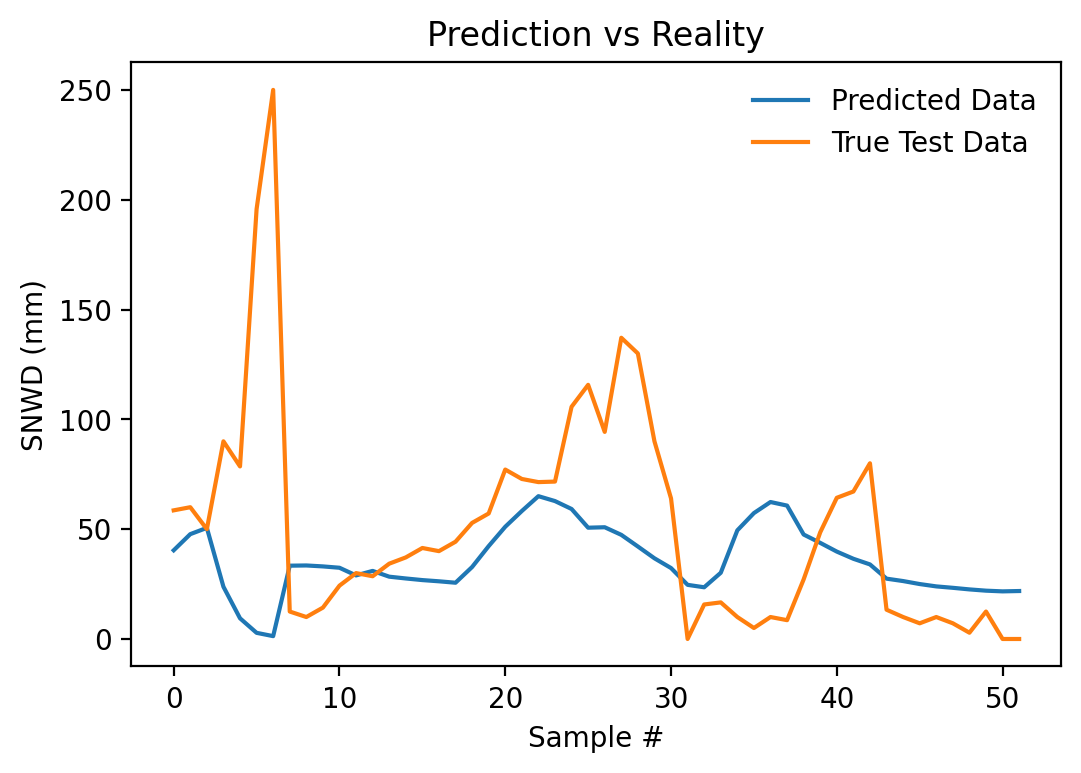

In [32]:
# Training and plotting

testvalues = 52
# testvalues=52 so that we're looking at 52 weeks worth of comparison data in the graphs

dataframenames = ['TMAX','TMIN','PRCP','SNOW','SNWD']
unitslist = ['C','C','mm','mm','mm']

trainingconditionlist(tabulatelisttest,testvalues,dataframenames,model1,20,4,unitslist)

# Can see functions that do it all at once works the same as when we do it all 
# seperately - i.e. confirms that the function works.

# Analysis


### TMAX

We can see from the graph that the model prediction of TMAX a year in advance is significantly better when trained over weekly data rather than daily data. The model has been able to identify the general trend of the data and a few of the fluctuations in the data, however still has plenty of room for improvement.

### TMIN

Again, the model performs fairly well, it can identify the general pattern of the data however does not predict the timing and amplitudes of the fluctuations to a good standard.

### PRCP and SNWD

The model does not predict as well for these variables as they do for TMAX and TMIN. The model somewhat predicts the trend in the data however not at a good quality and does not pick up the fluctuations well either.

### SNOW

There was insufficient weekly data to be able to train a model for SNOW and hence did not achieve any predictions for this variable.

# Potential extension 1

## Training a machine learning technique to predict 10 years into the future

The motivation for this section was just to complete potential extension 1. The approach done here is exactly the same as in machine learning task 1 here but I changed the offset to 519 (10 years = 520 weeks) to train the model to predict 10 years in advance. Observations were made from the results which led to further work, as documented below.

In [33]:
# Tabulate data

Datalisttest = [tmaxArray,tminArray,prcpArray,snowArray,snwdArray]
offset = 519 # (10 years = 520 weeks)
n_ts = 52 # (1 year = 52 weeks)
tabulatelisttest = tabulatelist(Datalisttest,offset,n_ts)

In [34]:
# Define model
model2=keras.models.Sequential()
model2.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model2.add(keras.layers.LSTM(50, activation='relu'))
model2.add(keras.layers.Dense(50,activation='relu'))
model2.add(keras.layers.Dense(50,activation='relu'))
model2.add(keras.layers.Dense(50,activation='relu'))
model2.add(keras.layers.Dense(1,activation="linear"))
model2.compile(loss='mean_squared_error',optimizer='adam')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 52, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-trai

In [35]:
# Shape check

for i in np.arange(0,len(tabulatelisttest),1):
    print(np.shape(tabulatelisttest[i]))

(45, 53)
(96, 53)
(15, 53)
(0, 53)
(0, 53)


TMIN
Epoch 1/20
5/5 [==============================] - 4s 182ms/step - loss: 454.2685 - val_loss: 586.3062
Epoch 2/20
5/5 [==============================] - 0s 44ms/step - loss: 419.2787 - val_loss: 487.1534
Epoch 3/20
5/5 [==============================] - 0s 47ms/step - loss: 245.3545 - val_loss: 495.8275
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 363.206 - 0s 86ms/step - loss: 363.2063 - val_loss: 576.6935
Epoch 5/20
5/5 [==============================] - 0s 71ms/step - loss: 383.1142 - val_loss: 316.6367
Epoch 6/20
5/5 [==============================] - 0s 63ms/step - loss: 143.9184 - val_loss: 104.4313
Epoch 7/20
5/5 [==============================] - 0s 76ms/step - loss: 80.0352 - val_loss: 198.0746
Epoch 8/20
5/5 [==============================] - 0s 77ms/step - loss: 140.7305 - val_loss: 226.1424
Epoch 9/20
5/5 [==============================] - 0s 98ms/step - loss: 124.4296 - val_loss: 175.2215
Epoch 10/20
5/5 [==============================] - 0s 100ms/

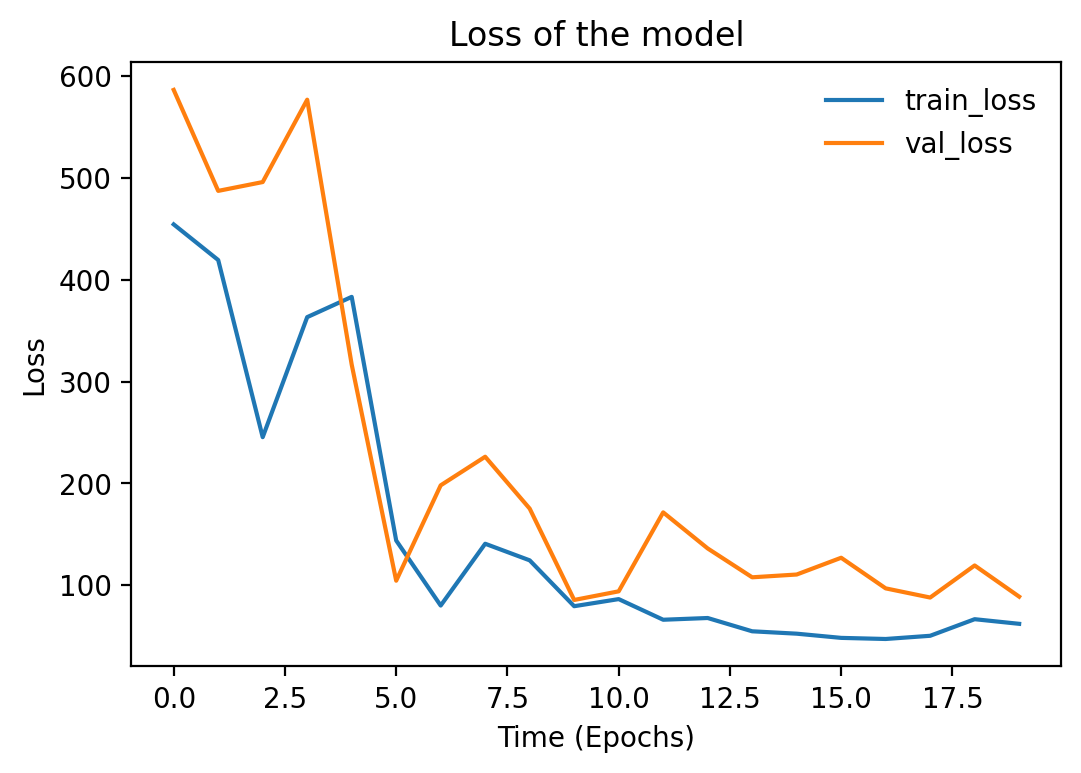

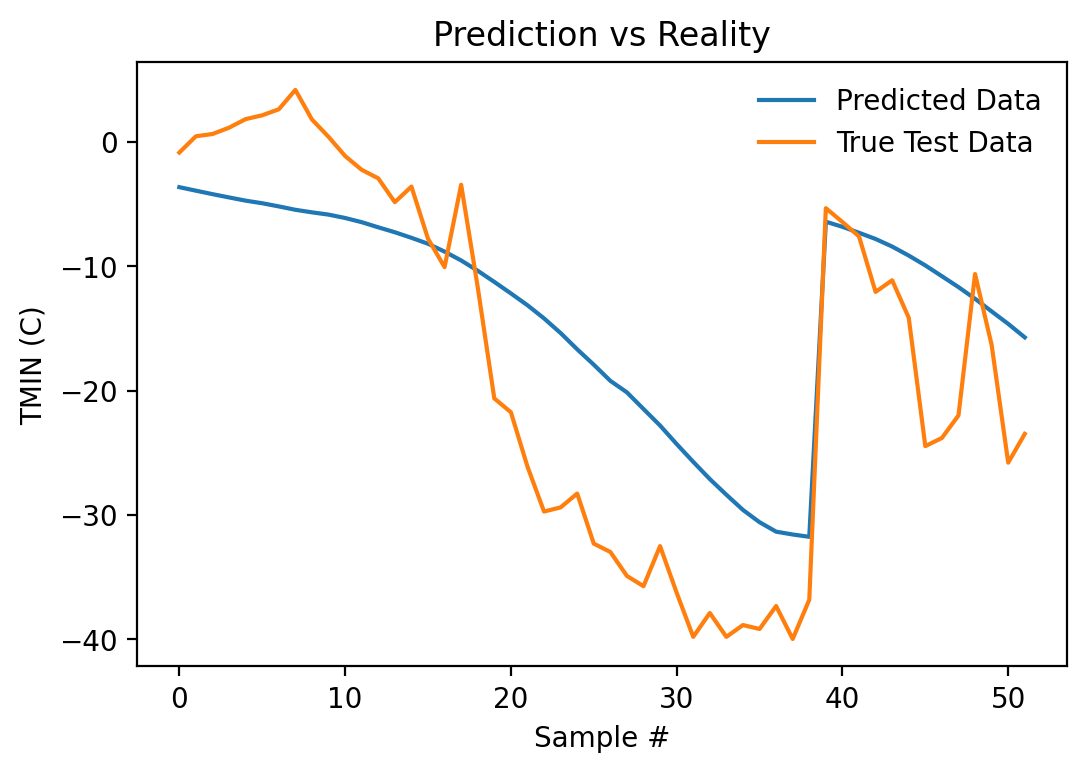

In [36]:
# Training

testvalues = 52
# testvalues=52 so that we're looking at 52 weeks worth of comparison data in the graphs

dataframenames = ['TMAX','TMIN','PRCP','SNOW','SNWD']

trainingconditionlist(tabulatelisttest,testvalues,dataframenames,model2,20,4,unitslist)

# Can see functions that do it all at once works the same as when we do it all 
# seperately - i.e. confirms that the function works.

# Analysis

TMIN was the only variable which had enough data to be able to take weekly averages and predict 10 years in advance. We can see that the model predictions do not compare well to the true data. The predictions somewhat follow the trend however does not pick up the majority of the fluctuations and, for the most part, the values of the predictions significantly differ from the true data. I believe this is because of the low quantity of data which the model is trained on. 

To test the effect the quantity of training data has on the quality of model predictions, I decided to find stations which have an abundance of data over all the variables which is done in a seperate notebook for readibility reasons. Nevertheless, out of the stations which have data for all the variables, station USW00024128, WINNEMUCCA MUNI AP, United States (933) was found to have the most data [4]. With this station identified, the same precodure as above can be carried out on this dataset to carry out the test.


In [37]:
#for i in range(len(dataframenames)):
#    print('{}'.format(dataframenames[i]))

In [38]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# Arbitrary number from 0 to 990
whichStat=933
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# So get the chosen station 

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))


USW00024128 is WINNEMUCCA MUNI AP, United States at 40.9017, -117.8081, 1309.4


In [39]:
# Extract data values

tmaxArray,tminArray,prcpArray,snowArray,snwdArray = extractdatavalues(933)

print(np.shape(tmaxArray))
print(np.shape(tminArray))
print(np.shape(prcpArray))
print(np.shape(snowArray))
print(np.shape(snwdArray))

(51801, 2)
(51801, 2)
(51829, 2)
(50428, 2)
(44675, 2)


### Plot data

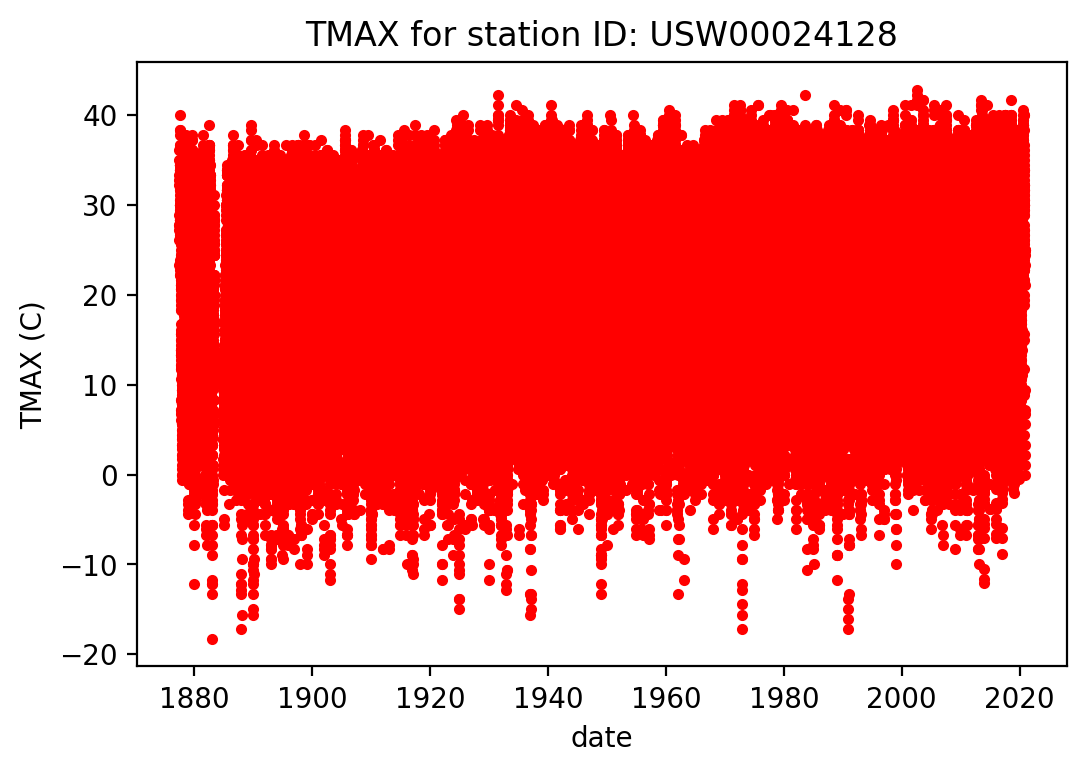

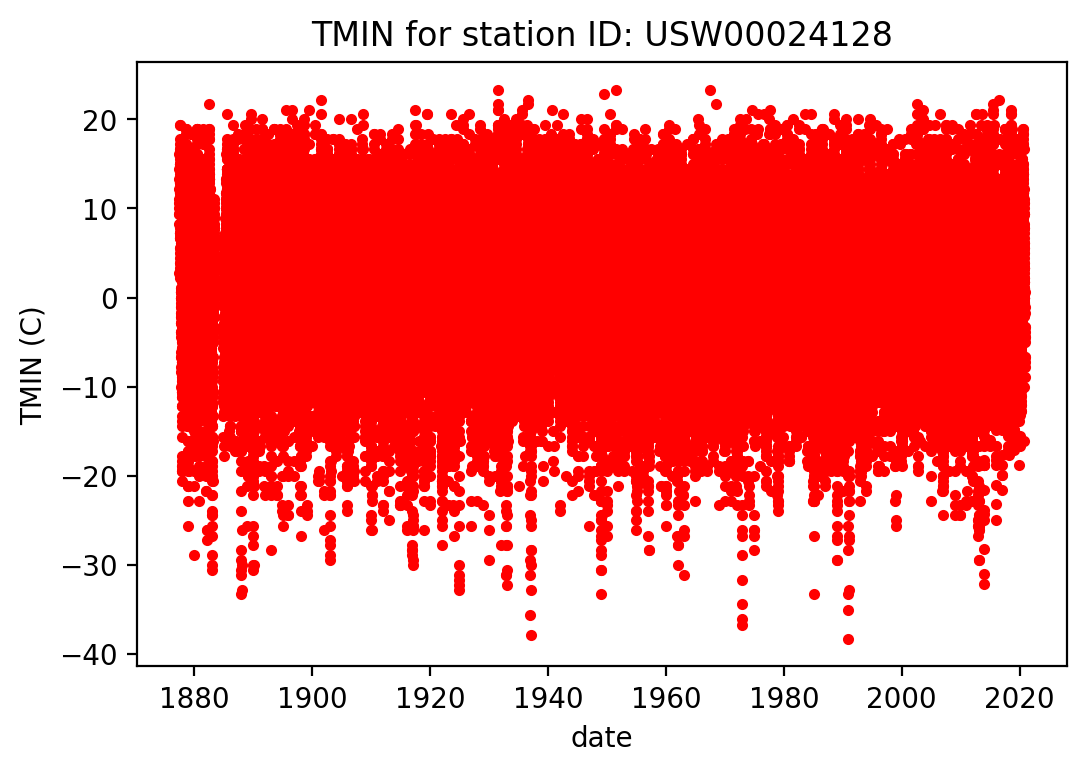

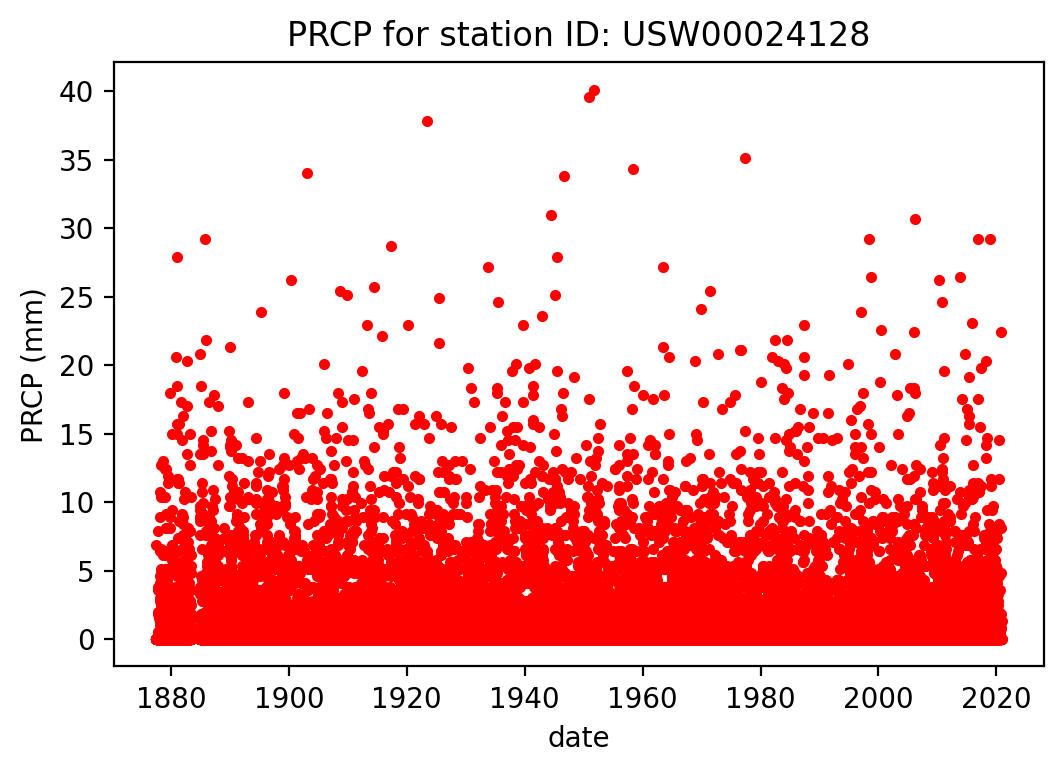

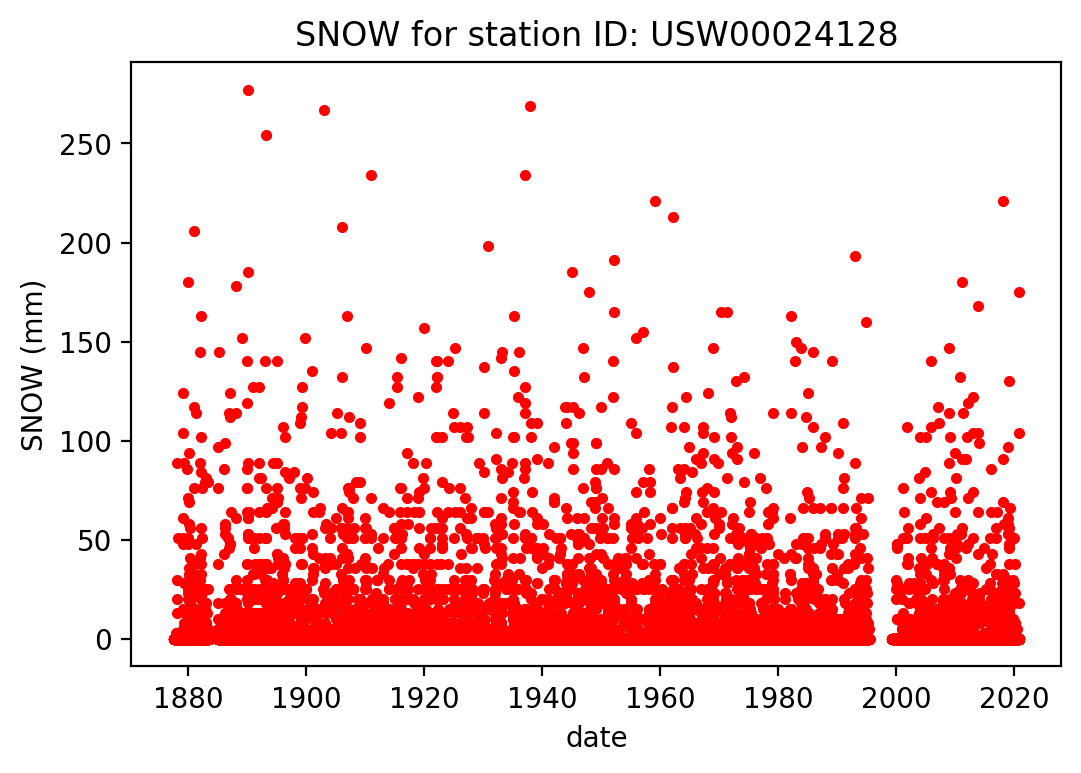

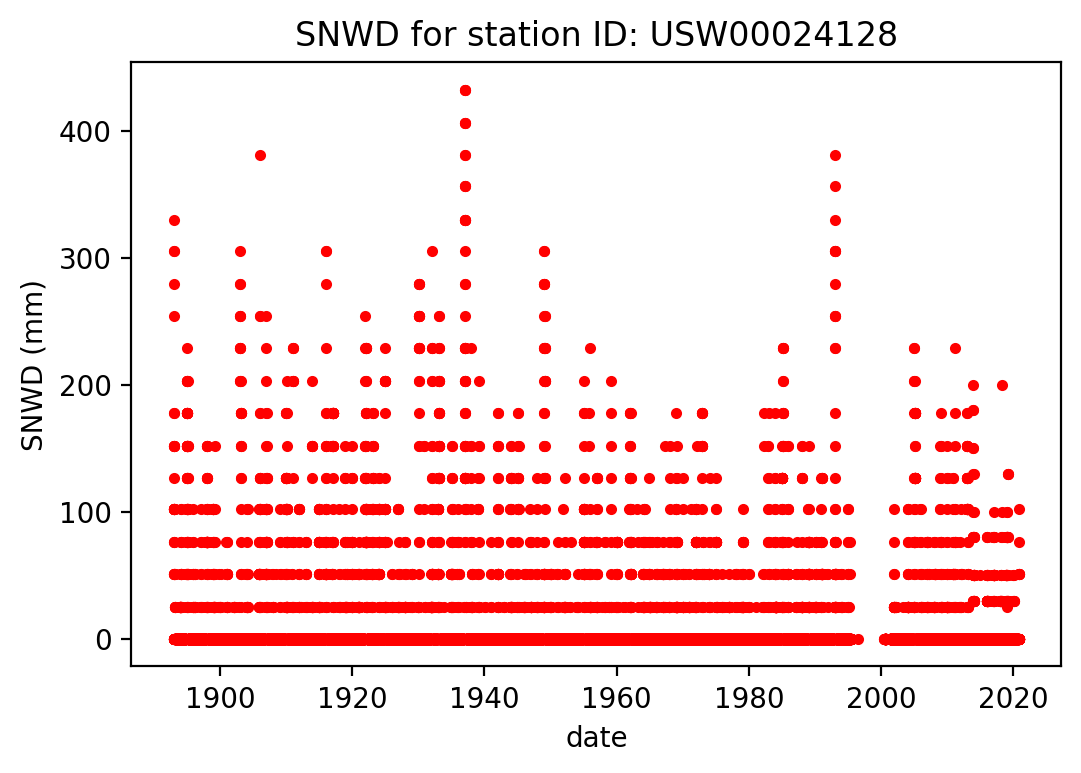

In [40]:
plotdata(tmaxArray,'TMAX','C',933)
plotdata(tminArray,'TMIN','C',933)
plotdata(prcpArray,'PRCP','mm',933)
plotdata(snowArray,'SNOW','mm',933)
plotdata(snwdArray,'SNWD','mm',933)

Can see there is a tremendous amount of data, let's reduce it slightly and see what we can observe.

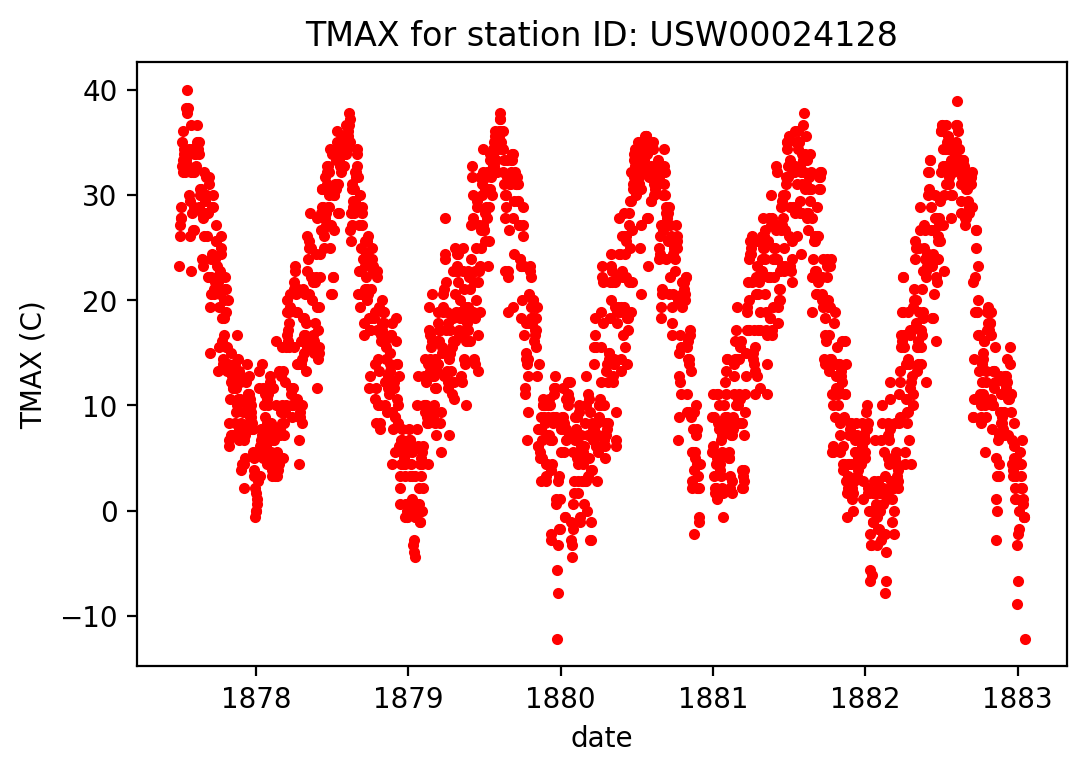

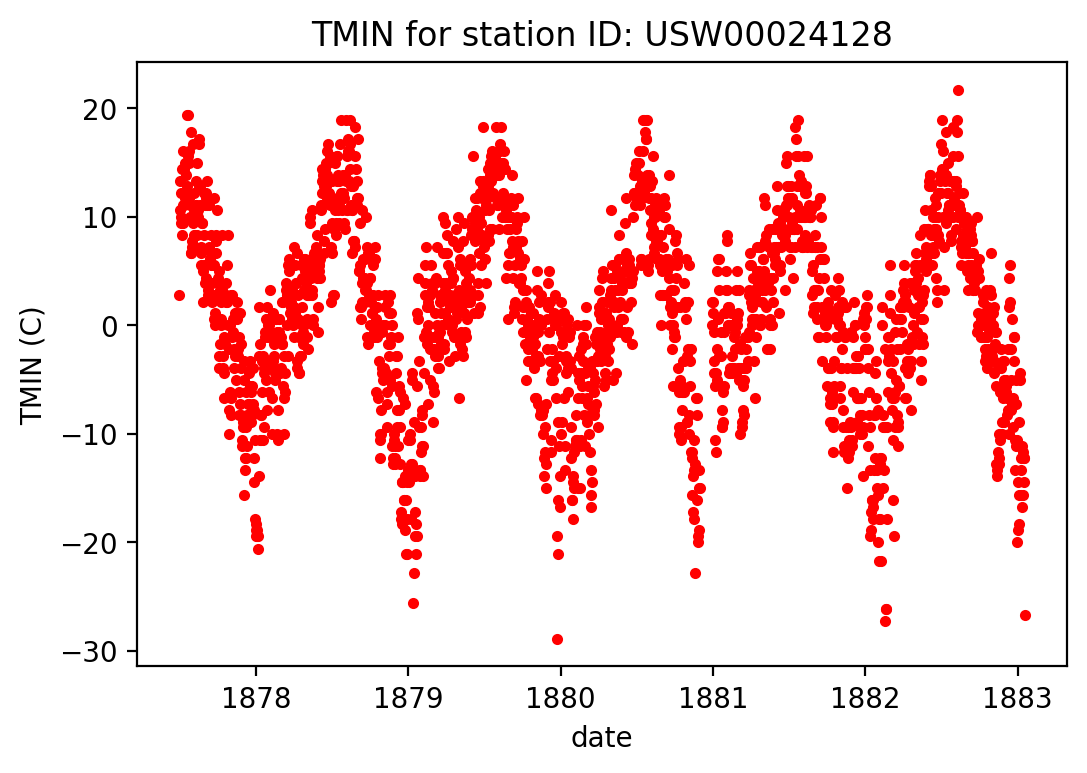

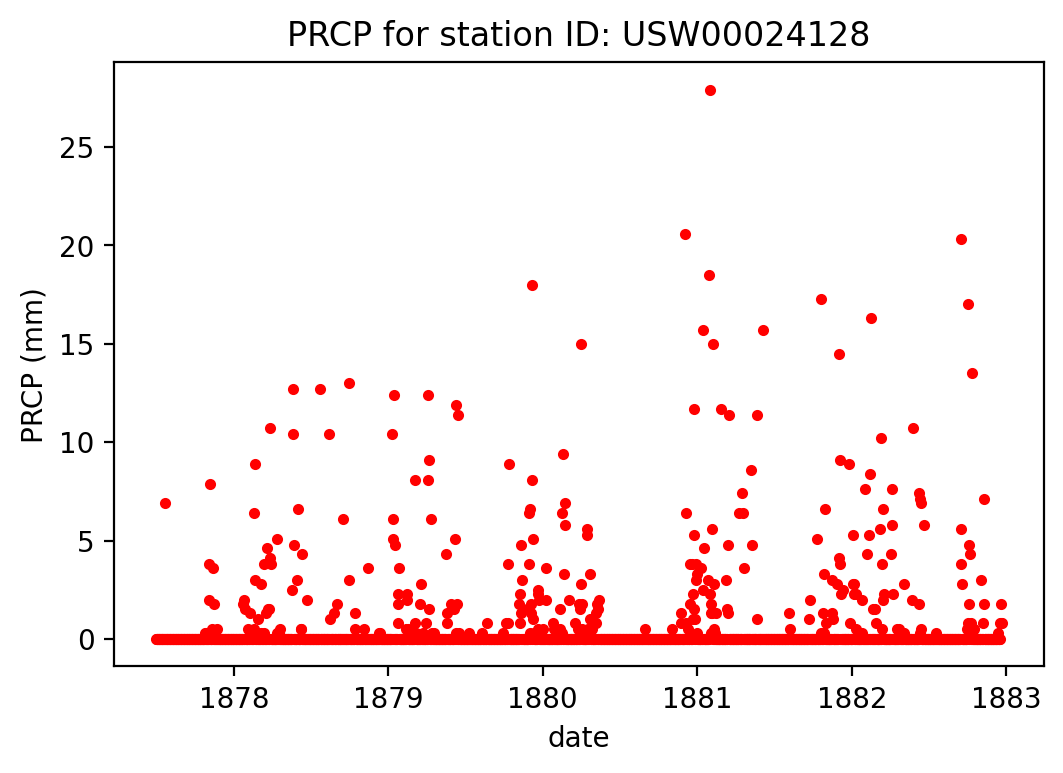

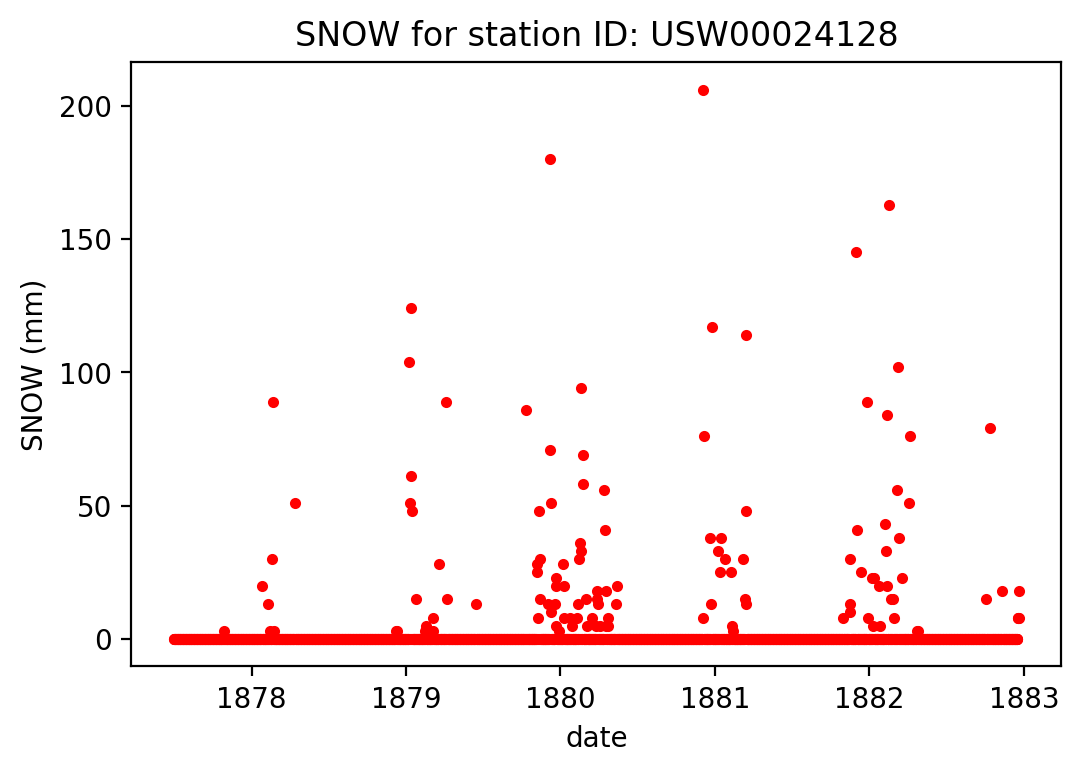

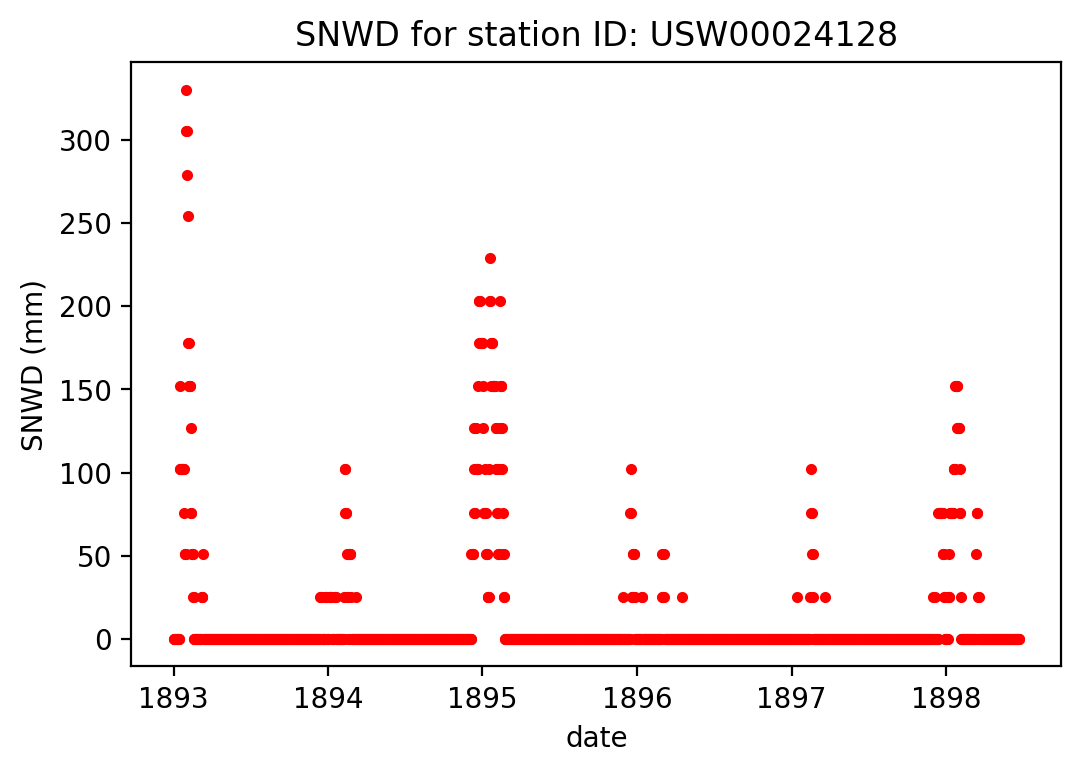

In [41]:
plotdata(tmaxArray[:2000],'TMAX','C',933)
plotdata(tminArray[:2000],'TMIN','C',933)
plotdata(prcpArray[:2000],'PRCP','mm',933)
plotdata(snowArray[:2000],'SNOW','mm',933)
plotdata(snwdArray[:2000],'SNWD','mm',933)

### Observation

We can blatantly observe a sort of wave pettern with the TMAX and TMIN data whereas we cannot directly observe a pattern for the other variables.

In [42]:
# Tabulate data

Data933list = [tmaxArray,tminArray,prcpArray,snowArray,snwdArray]
offset = 519
n_ts = 52
tabulate933list = tabulatelist(Data933list,offset,n_ts)

In [43]:
# Shape check

for i in np.arange(0,len(tabulate933list),1):
    print(np.shape(tabulate933list[i]))

(6730, 53)
(6730, 53)
(6784, 53)
(6335, 53)
(5462, 53)


In [44]:
# Define model
model3=keras.models.Sequential()
model3.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model3.add(keras.layers.LSTM(50, activation='relu'))
model3.add(keras.layers.Dense(50,activation='relu'))
model3.add(keras.layers.Dense(50,activation='relu'))
model3.add(keras.layers.Dense(50,activation='relu'))
model3.add(keras.layers.Dense(1,activation="linear"))
model3.compile(loss='mean_squared_error',optimizer='adam')
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 52, 100)           40800     
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-trai

TMAX
Epoch 1/20
13/13 [==============================] - 7s 322ms/step - loss: 381.1866 - val_loss: 128.2902
Epoch 2/20
13/13 [==============================] - 4s 315ms/step - loss: 154.6442 - val_loss: 112.1192
Epoch 3/20
13/13 [==============================] - 4s 301ms/step - loss: 61.2506 - val_loss: 70.0813
Epoch 4/20
13/13 [==============================] - 4s 286ms/step - loss: 69.1553 - val_loss: 69.7210
Epoch 5/20
13/13 [==============================] - 4s 266ms/step - loss: 45.2784 - val_loss: 30.9886
Epoch 6/20
13/13 [==============================] - 4s 286ms/step - loss: 27.0490 - val_loss: 18.8582
Epoch 7/20
13/13 [==============================] - 4s 279ms/step - loss: 19.7441 - val_loss: 17.5031
Epoch 8/20
13/13 [==============================] - 4s 317ms/step - loss: 19.9193 - val_loss: 19.5079
Epoch 9/20
13/13 [==============================] - 4s 285ms/step - loss: 21.4718 - val_loss: 28.5354
Epoch 10/20
13/13 [==============================] - 4s 282ms/step - loss

Epoch 1/20
13/13 [==============================] - 4s 303ms/step - loss: 510.8260 - val_loss: 527.7686
Epoch 2/20
13/13 [==============================] - 4s 326ms/step - loss: 496.7245 - val_loss: 509.8601
Epoch 3/20
13/13 [==============================] - 4s 325ms/step - loss: 484.9615 - val_loss: 513.1470
Epoch 4/20
13/13 [==============================] - 4s 329ms/step - loss: 484.4524 - val_loss: 514.8899
Epoch 5/20
13/13 [==============================] - 3s 247ms/step - loss: 484.2615 - val_loss: 505.1778
Epoch 6/20
13/13 [==============================] - 4s 323ms/step - loss: 516.7046 - val_loss: 545.5740
Epoch 7/20
13/13 [==============================] - 4s 330ms/step - loss: 520.1028 - val_loss: 533.5194
Epoch 8/20
13/13 [==============================] - 3s 226ms/step - loss: 502.4764 - val_loss: 517.5069
Epoch 9/20
13/13 [==============================] - 4s 343ms/step - loss: 489.8566 - val_loss: 504.0245
Epoch 10/20
13/13 [==============================] - 3s 236ms/st

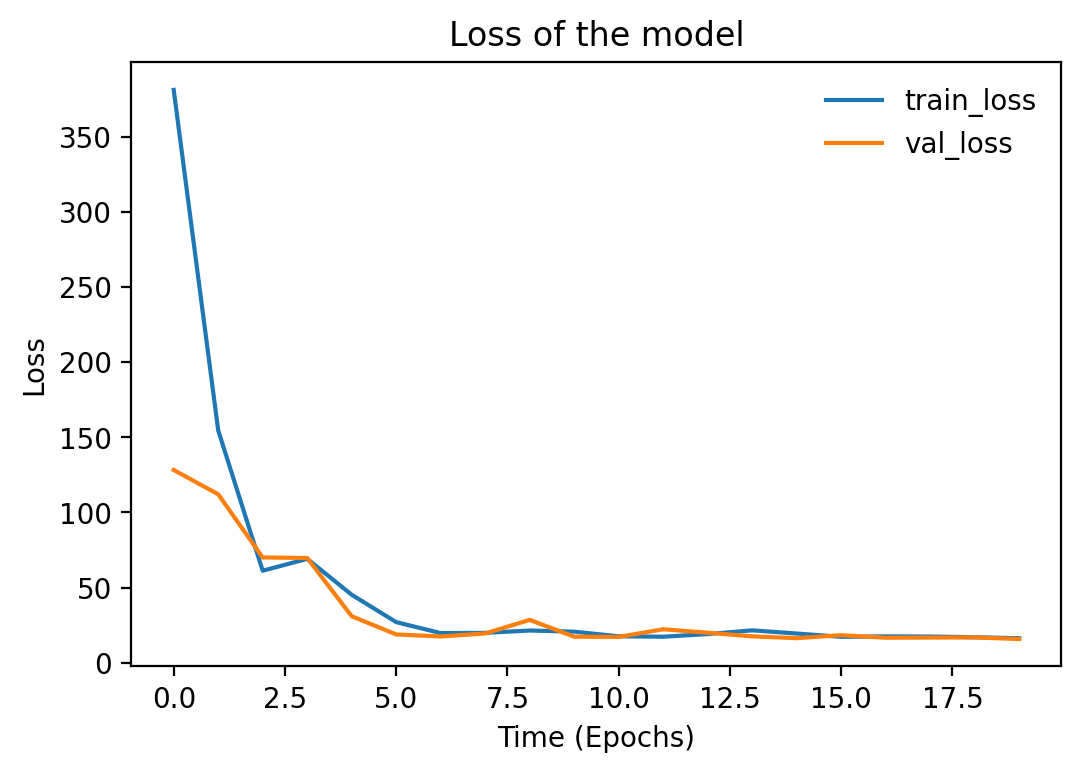

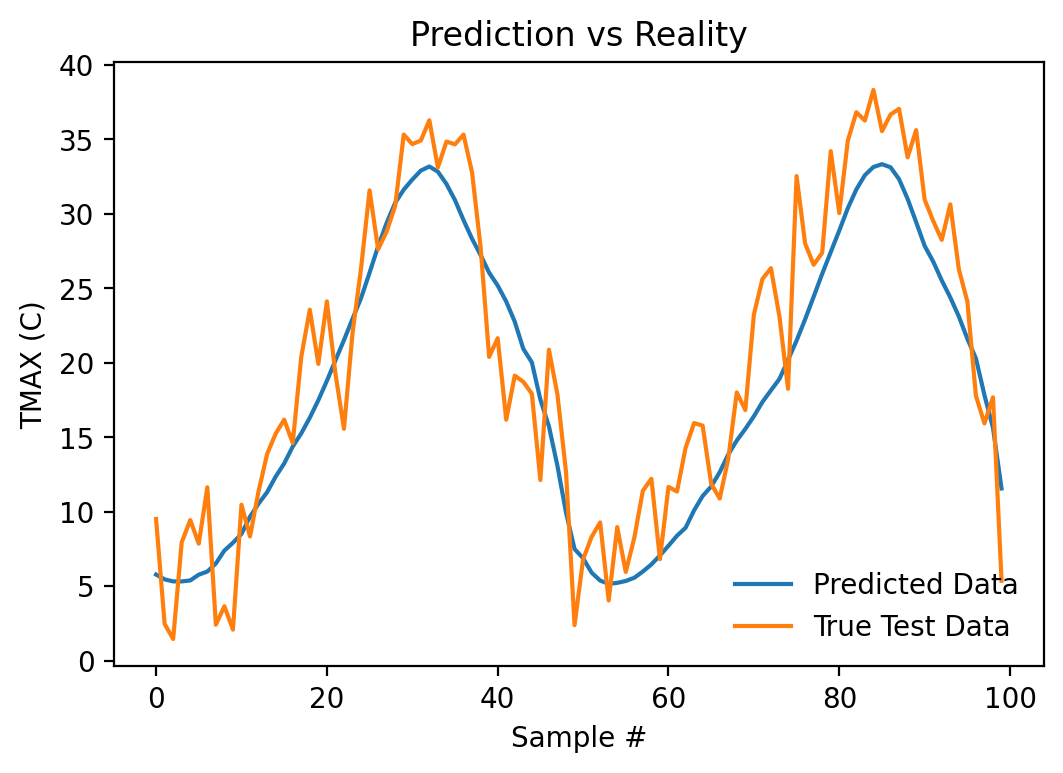

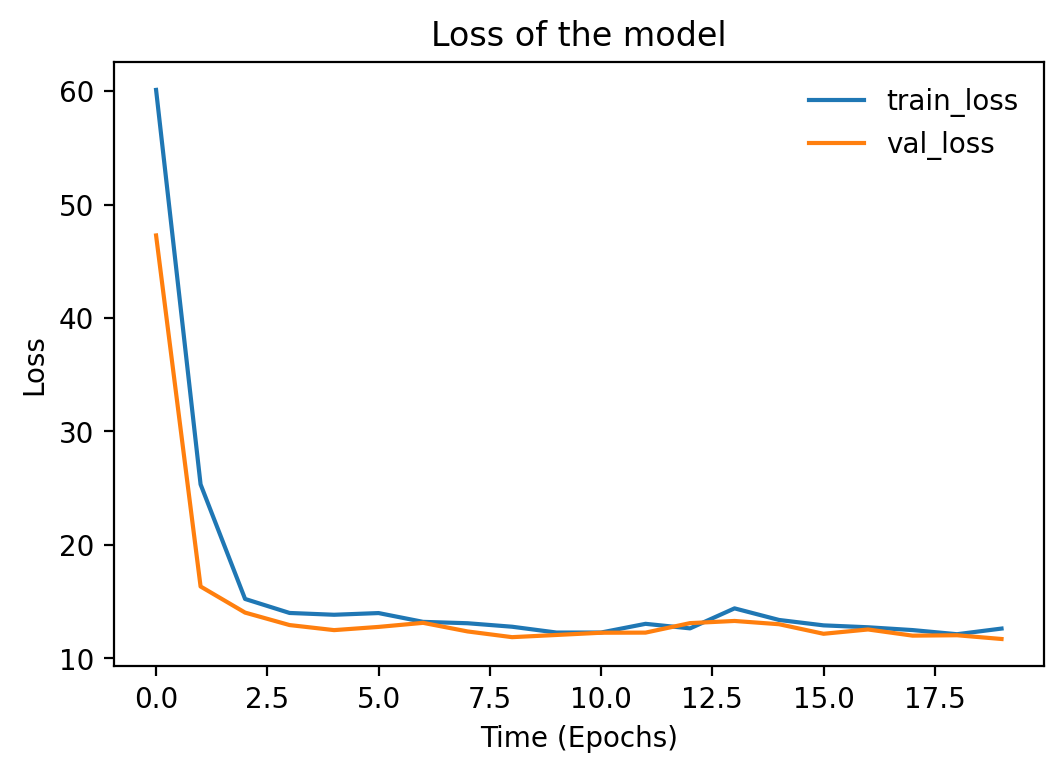

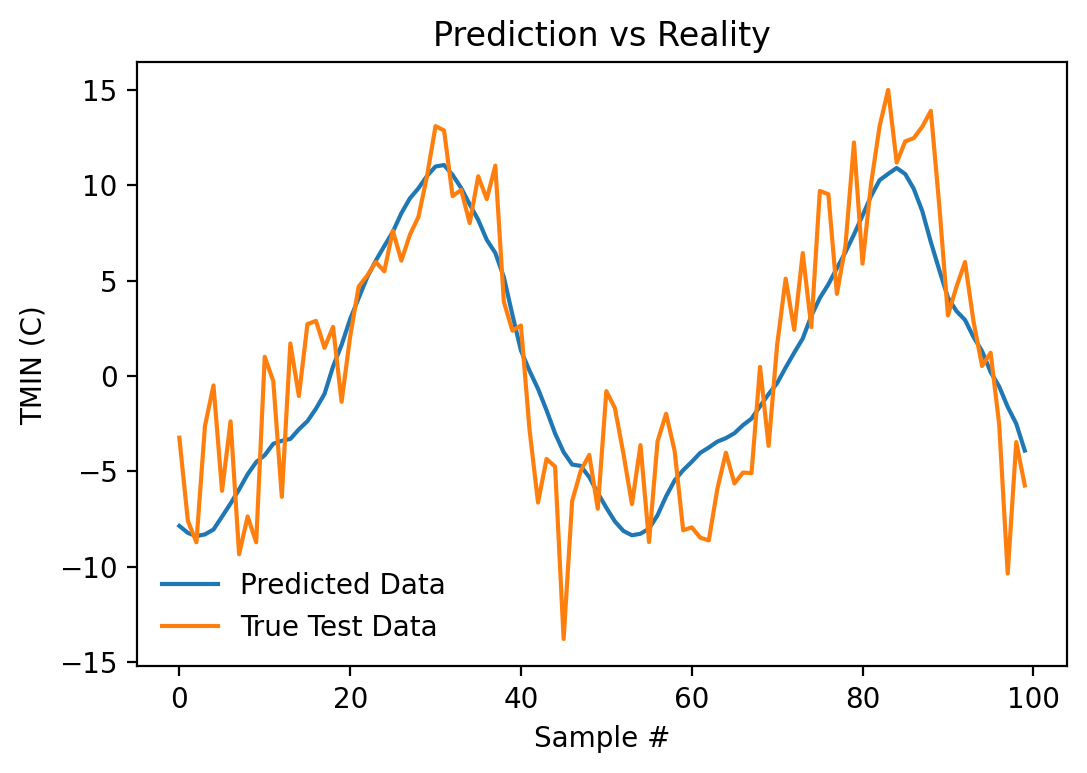

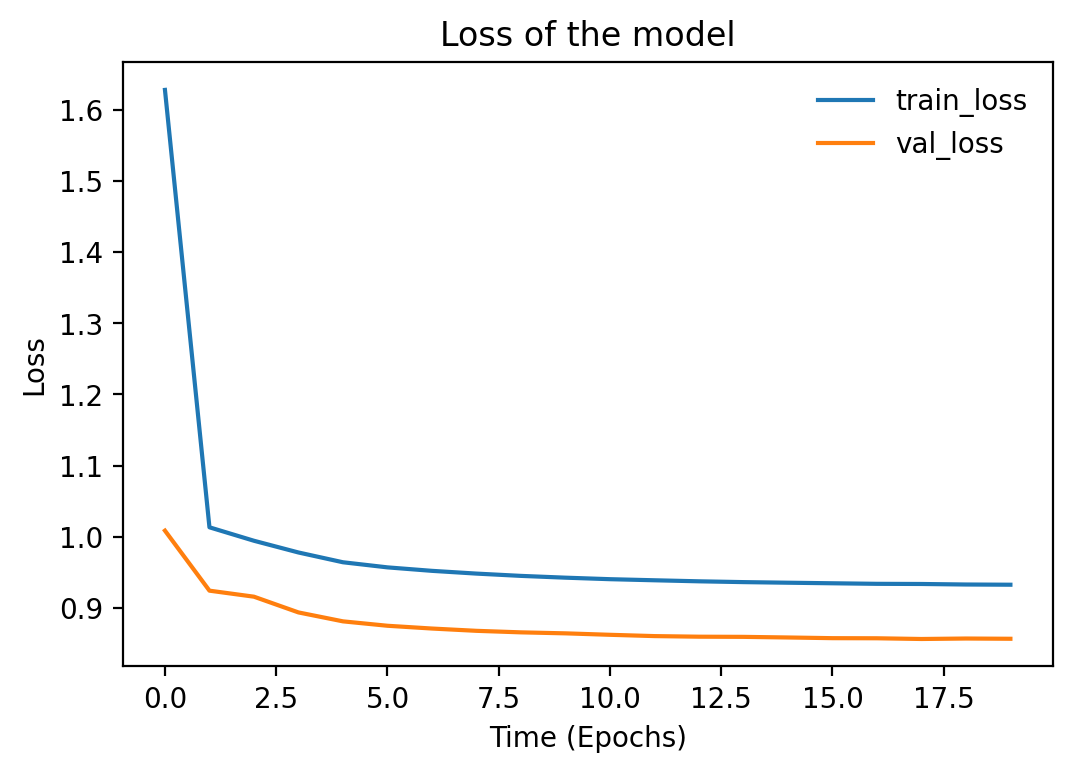

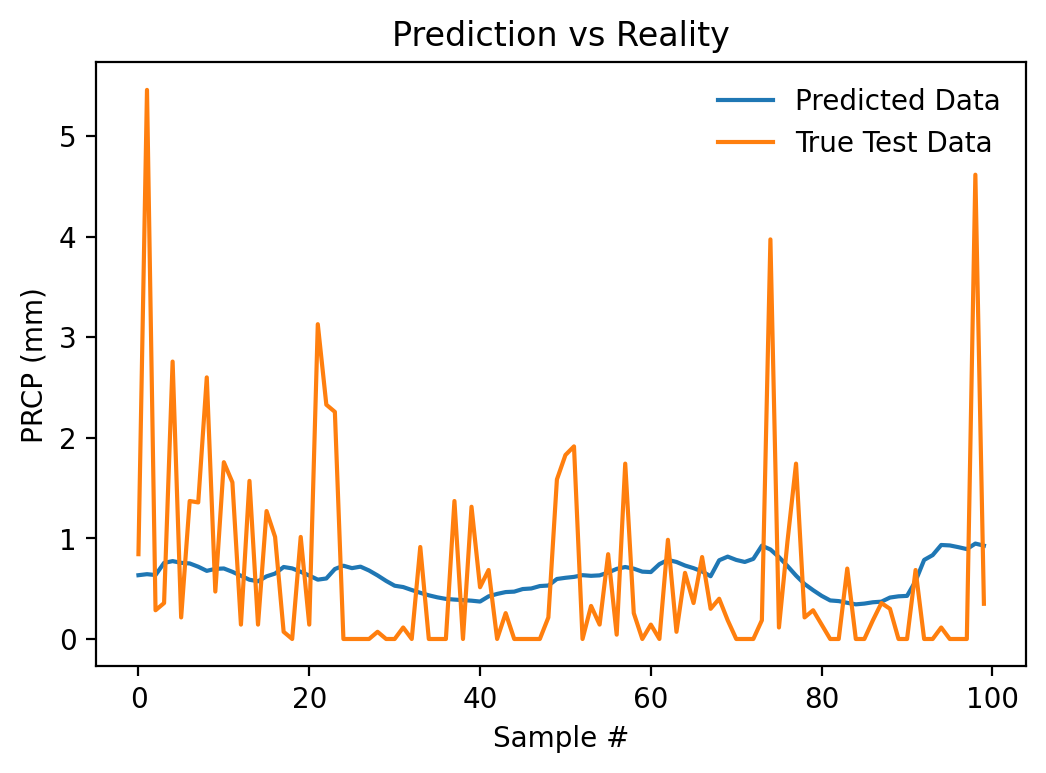

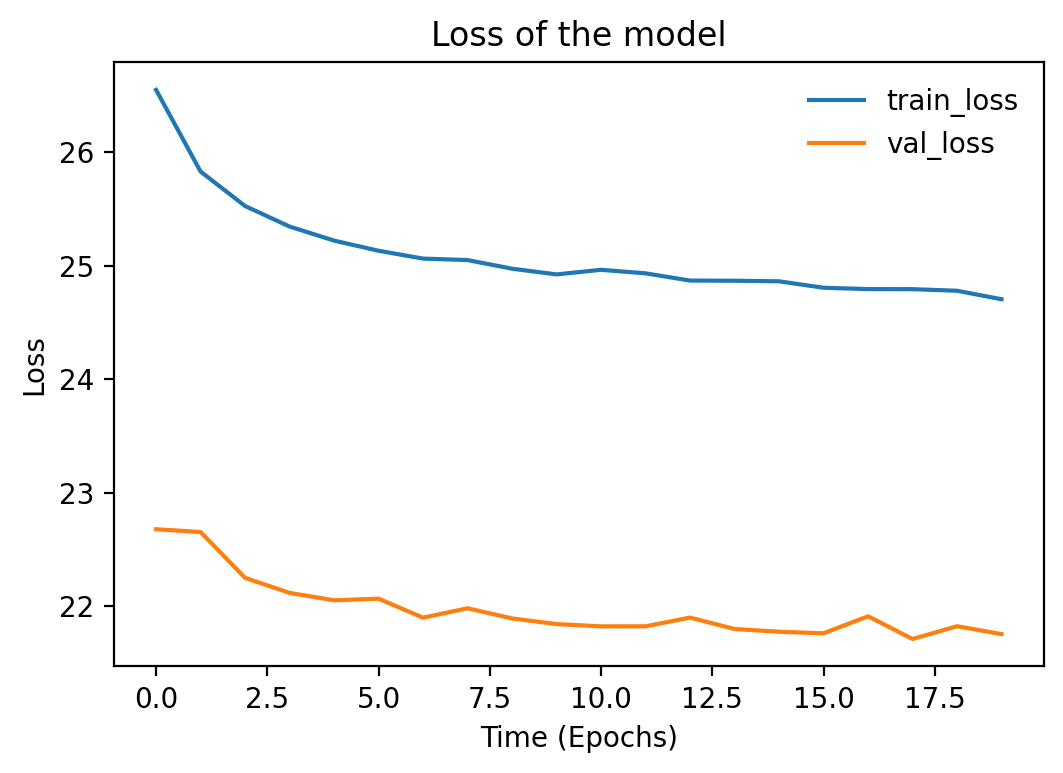

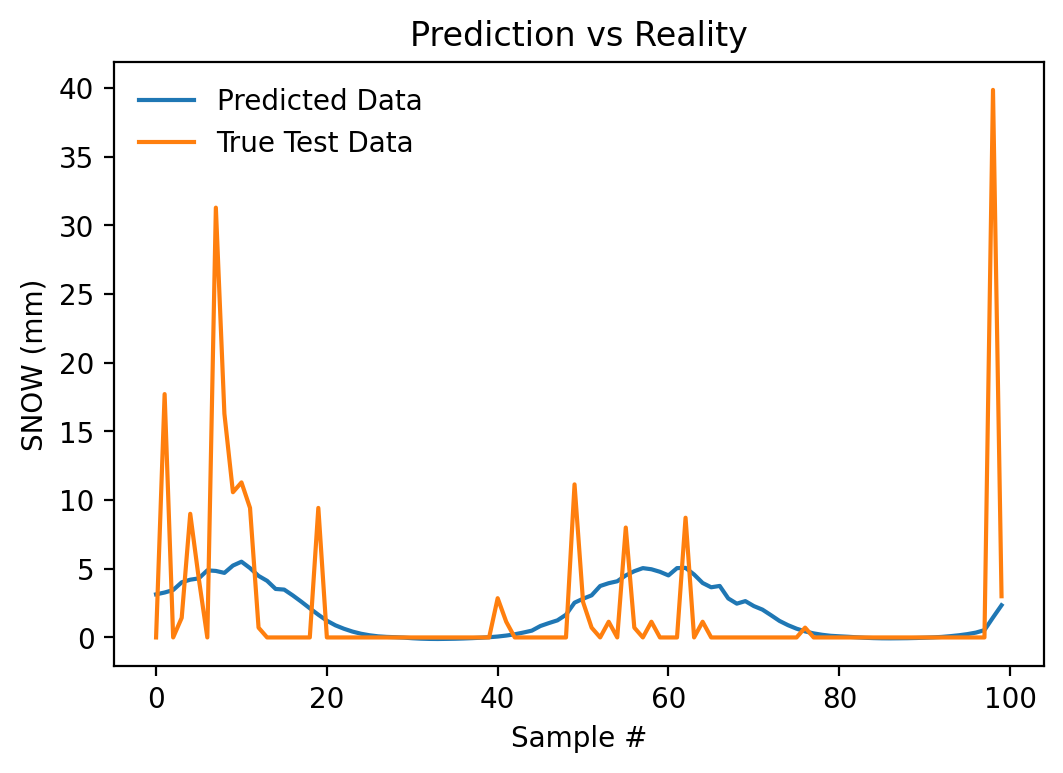

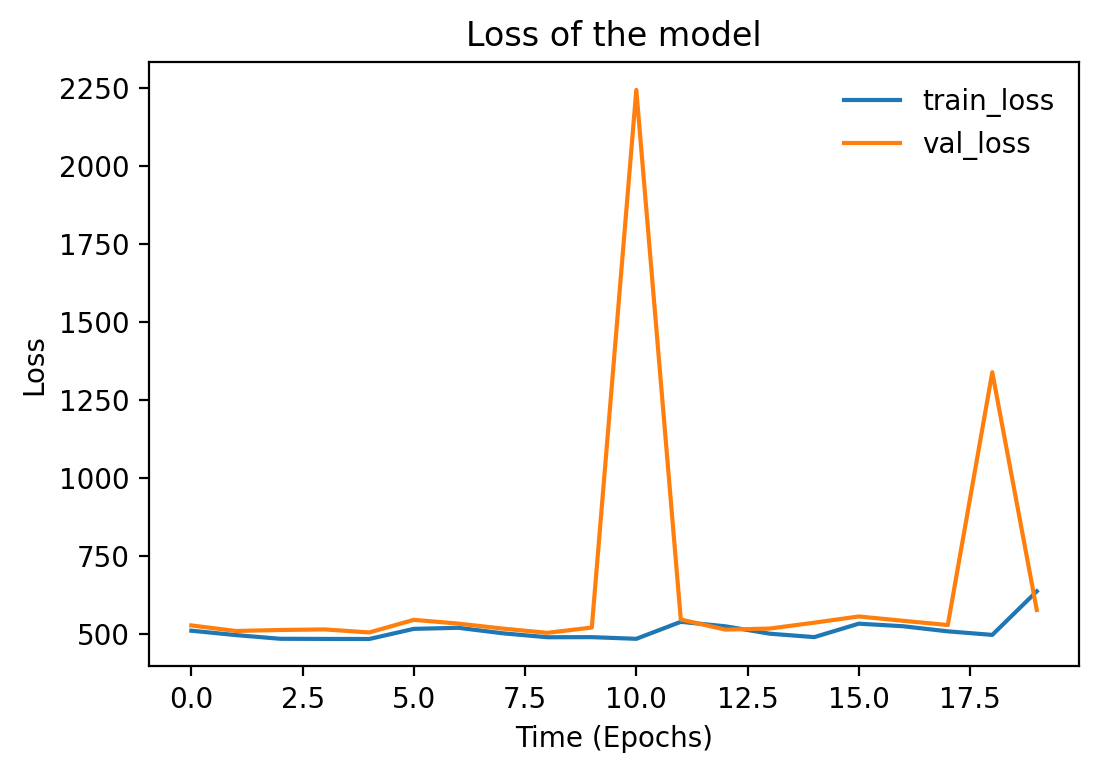

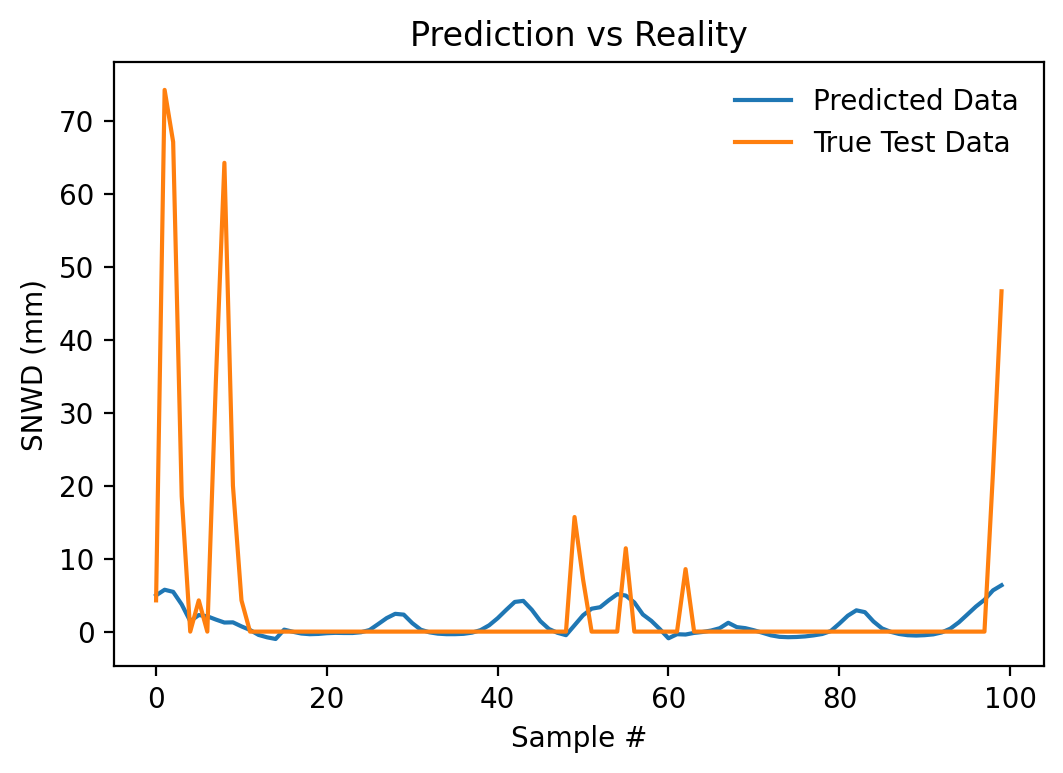

In [45]:
# Training and predictions

testvalues = 100
# testvalues=100 as we now have a lot more data therefore
# just increased the testvalues so that we have more comparison data

dataframenames = ['TMAX','TMIN','PRCP','SNOW','SNWD']

trainingconditionlist(tabulate933list,testvalues,dataframenames,model3,20,12,unitslist)

# Analysis

We can see the model predicts the general trend of the TMAX and TMIN however does not pick up the fluctuations well. The predictions of this model also appears to be better than when a model is trained on the dataset with less values, hence providing evidence that the greater the quantity of training data, the better the model predictions which makes sense as there would be more data which the model can be trained on, hence leading to better training and therefore performance.

Another observation we can make from these results, which is a recurring observation throughout the notebook, is that the models do not predict the other variables as well as they do the temperature variables. A potential reasons for this could be the order of the training; the reason for the low quality predictions of the other variables may be because I'm training the model on the temperature data first. Another reason could be that the other variables do not follow a pattern like TMAX and TMIN do.


# Does order of training affect results? 

In this section, we address the question in the title. I kept the model configuration and training parameters the same as in the previous section so that the only difference is that we're training the model on a single variable only.

### Training model on SNWD only

In [46]:
# Define model
model4=keras.models.Sequential()
model4.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model4.add(keras.layers.LSTM(50, activation='relu'))
model4.add(keras.layers.Dense(50,activation='relu'))
model4.add(keras.layers.Dense(50,activation='relu'))
model4.add(keras.layers.Dense(50,activation='relu'))
model4.add(keras.layers.Dense(1,activation="linear"))
model4.compile(loss='mean_squared_error',optimizer='adam')
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 52, 100)           40800     
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 50)                2550      
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-trai

Epoch 1/20
13/13 [==============================] - 7s 313ms/step - loss: 566.7986 - val_loss: 572.7217
Epoch 2/20
13/13 [==============================] - 3s 247ms/step - loss: 515.5722 - val_loss: 512.6162
Epoch 3/20
13/13 [==============================] - 4s 275ms/step - loss: 486.8737 - val_loss: 507.5574
Epoch 4/20
13/13 [==============================] - 3s 227ms/step - loss: 483.0775 - val_loss: 506.7354
Epoch 5/20
13/13 [==============================] - 3s 227ms/step - loss: 475.9924 - val_loss: 503.8651
Epoch 6/20
13/13 [==============================] - 3s 212ms/step - loss: 479.7854 - val_loss: 504.3516
Epoch 7/20
13/13 [==============================] - 3s 222ms/step - loss: 470.7594 - val_loss: 492.5538
Epoch 8/20
13/13 [==============================] - 3s 233ms/step - loss: 469.9803 - val_loss: 493.4015
Epoch 9/20
13/13 [==============================] - 3s 228ms/step - loss: 464.6089 - val_loss: 486.9245
Epoch 10/20
13/13 [==============================] - 3s 259ms/st

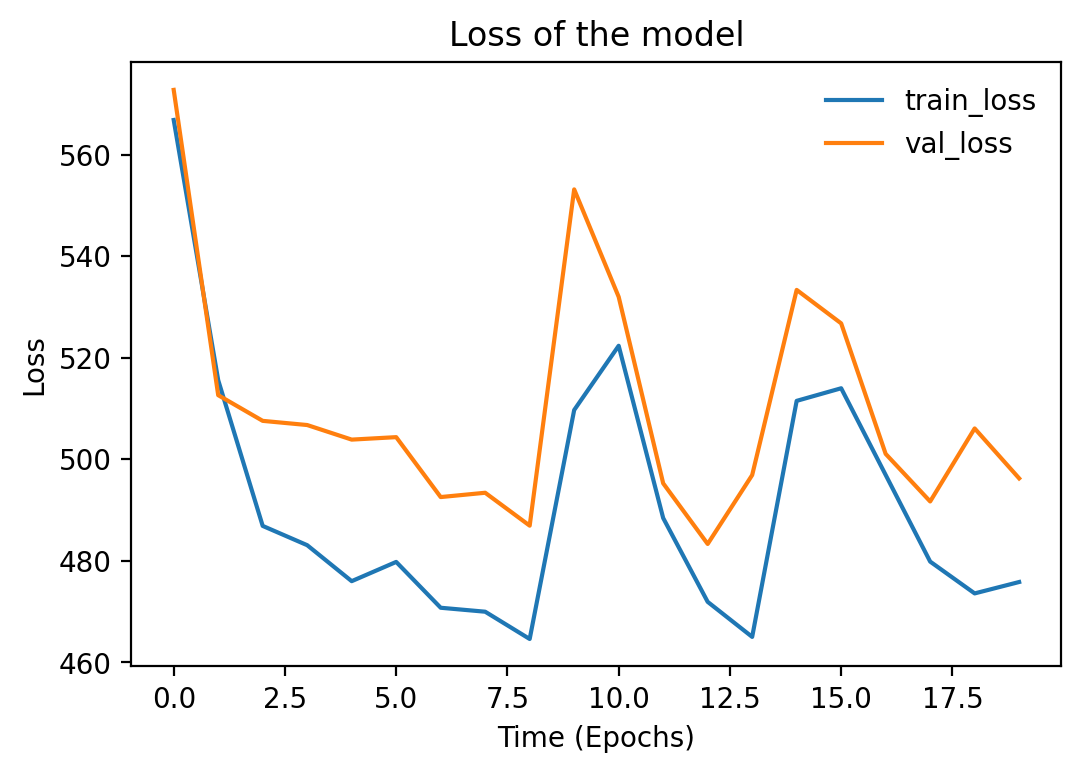

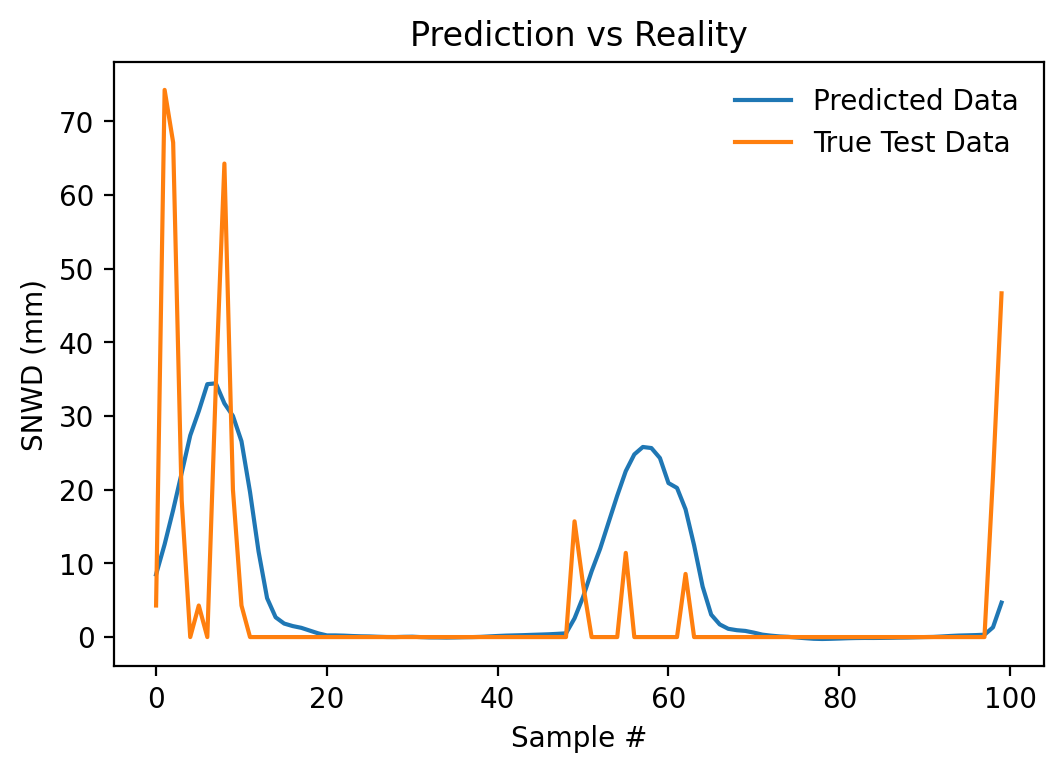

In [47]:
# Training and plotting

# Preparing data for training
train_data,train_label,val_data,val_label,test_data,test_label = tableformtotrainingform(tabulate933list[4],testvalues)
    
history4=model4.fit(train_data, train_label,epochs=20,batch_size=round( np.shape(train_data)[0]/12 ),verbose=1,validation_data=(val_data,val_label))
# Batchsize defined in this way to ensure it's a good number
# Not too little not too large

# Plot loss
fig,ax=plt.subplots()
ax.plot(history4.history['loss'], label='train_loss')
ax.plot(history4.history['val_loss'], label='val_loss')
plt.title("Loss of the model")
plt.xlabel("Time (Epochs)")
plt.ylabel("Loss")
ax.legend()    

# Plot predictions
test_predict=model4.predict(test_data)
fig,ax=plt.subplots()
ax.plot(test_predict,label="Predicted Data")
ax.plot(test_label,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample #")
ax.set_ylabel('SNWD (mm)')
ax.legend()

### Training model on PRCP only

In [48]:
# Define model
model5=keras.models.Sequential()
model5.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model5.add(keras.layers.LSTM(50, activation='relu'))
model5.add(keras.layers.Dense(50,activation='relu'))
model5.add(keras.layers.Dense(50,activation='relu'))
model5.add(keras.layers.Dense(50,activation='relu'))
model5.add(keras.layers.Dense(1,activation="linear"))
model5.compile(loss='mean_squared_error',optimizer='adam')
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 52, 100)           40800     
                                                                 
 lstm_11 (LSTM)              (None, 50)                30200     
                                                                 
 dense_19 (Dense)            (None, 50)                2550      
                                                                 
 dense_20 (Dense)            (None, 50)                2550      
                                                                 
 dense_21 (Dense)            (None, 50)                2550      
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-trai

Epoch 1/20
12/12 [==============================] - 8s 382ms/step - loss: 1.1970 - val_loss: 0.8780
Epoch 2/20
12/12 [==============================] - 4s 377ms/step - loss: 0.9606 - val_loss: 0.8597
Epoch 3/20
12/12 [==============================] - 5s 432ms/step - loss: 0.9355 - val_loss: 0.8459
Epoch 4/20
12/12 [==============================] - 6s 465ms/step - loss: 0.9355 - val_loss: 0.8451
Epoch 5/20
12/12 [==============================] - 4s 348ms/step - loss: 0.9356 - val_loss: 0.8508
Epoch 6/20
12/12 [==============================] - 4s 331ms/step - loss: 0.9300 - val_loss: 0.8469
Epoch 7/20
12/12 [==============================] - 4s 304ms/step - loss: 0.9289 - val_loss: 0.8457
Epoch 8/20
12/12 [==============================] - 4s 342ms/step - loss: 0.9281 - val_loss: 0.8444
Epoch 9/20
12/12 [==============================] - 5s 426ms/step - loss: 0.9272 - val_loss: 0.8431
Epoch 10/20
12/12 [==============================] - 4s 374ms/step - loss: 0.9287 - val_loss: 0.8435

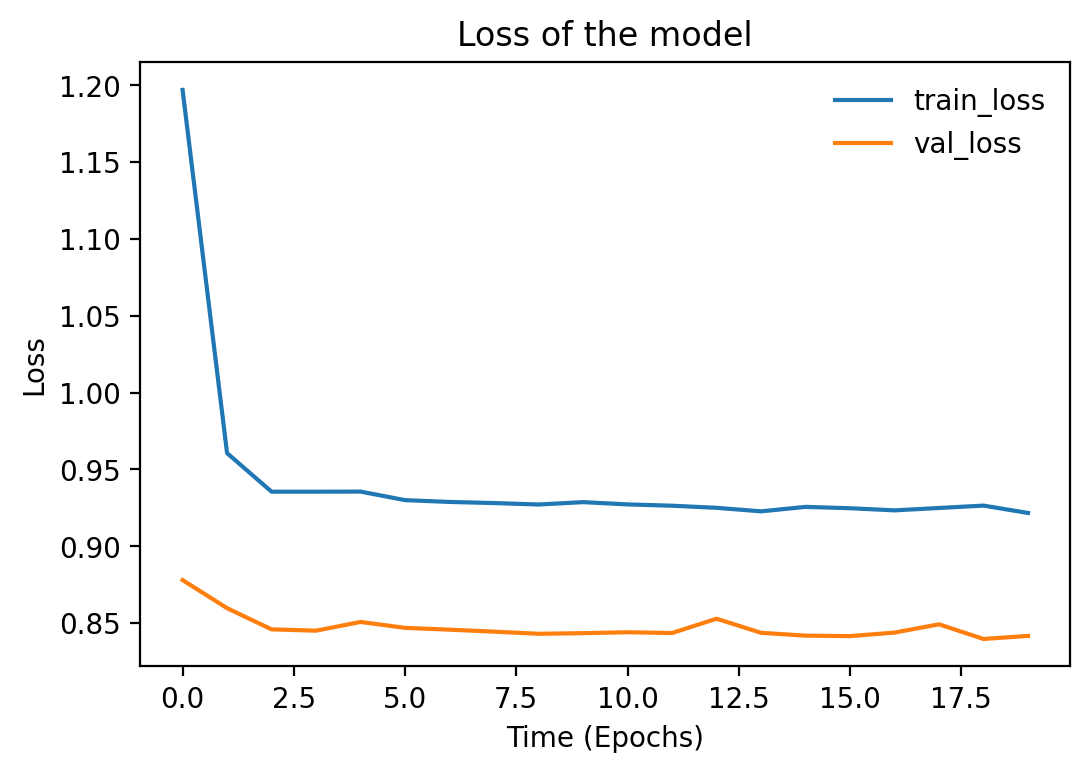

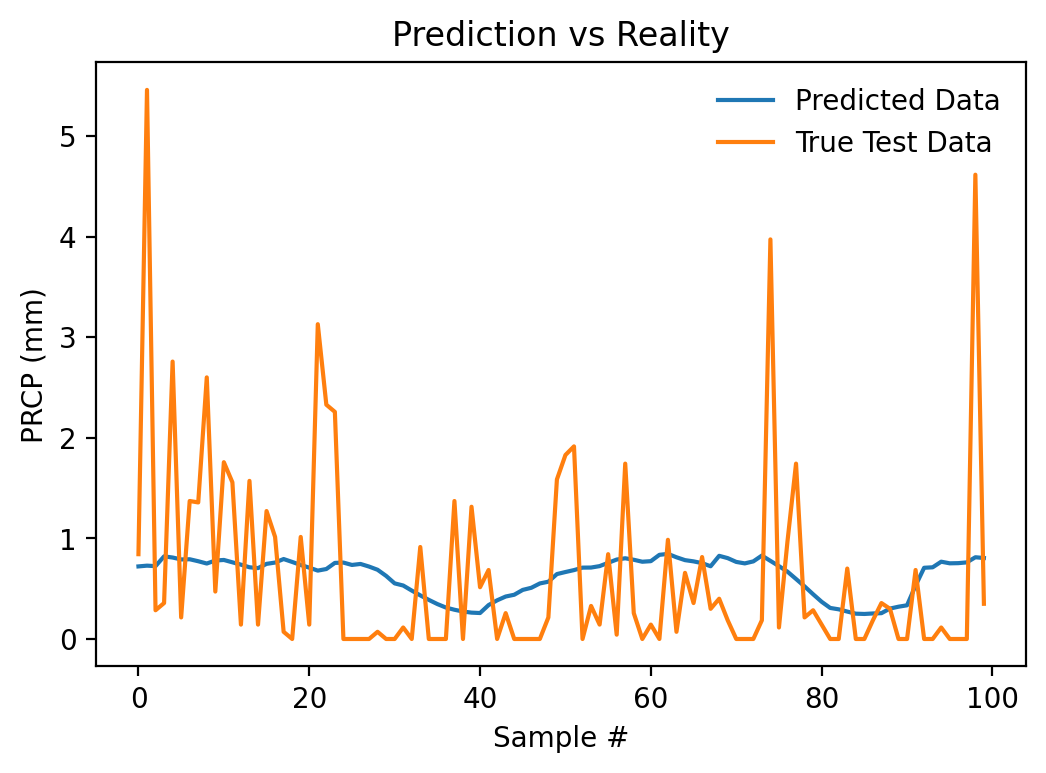

In [49]:
# Training and plotting

# Preparing data for training
train_data,train_label,val_data,val_label,test_data,test_label = tableformtotrainingform(tabulate933list[2],testvalues)
    
history5=model5.fit(train_data, train_label,epochs=20,batch_size=round( np.shape(train_data)[0]/12 ),verbose=1,validation_data=(val_data,val_label))
# Batchsize defined in this way to ensure it's a good number
# Not too little not too large

# Plot loss
fig,ax=plt.subplots()
ax.plot(history5.history['loss'], label='train_loss')
ax.plot(history5.history['val_loss'], label='val_loss')
plt.title("Loss of the model")
plt.xlabel("Time (Epochs)")
plt.ylabel("Loss")
ax.legend()    

# Plot predictions
test_predict=model5.predict(test_data)
fig,ax=plt.subplots()
ax.plot(test_predict,label="Predicted Data")
ax.plot(test_label,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample #")
ax.set_ylabel('PRCP (mm)')
ax.legend()

# Analysis

We can see that training a model only on PRCP or SNWD data still leads to poor quality predictions and therefore insufficient evidence to believe that training the model on TMAX and TMIN first affects the training of the model on the other variables. However, there is still the case where training the data to predict 10 years in advance is so difficult that no matter what order the model is trained in, the predictions of the PRCP,SNOW and SNWD variables will be of poor quality.

# Is predicting 10 years in advance too difficult?

In this section, we use the same dataset, model configuration and training parameters as in the previous 2 sections but we changed the offset so that we're training the model to predict only 1 year ahead rather than 10, similar to what was done in machine learning task 1.

In [50]:
# Tabulate data

offset = 51
n_ts = 8
tabulate933list = tabulatelist(Data933list,offset,n_ts)

In [51]:
# Shape check

for i in np.arange(0,len(tabulate933list),1):
    print(np.shape(tabulate933list[i]))

(7275, 9)
(7275, 9)
(7288, 9)
(7030, 9)
(6260, 9)


### Traning model on prcp only

In [52]:
# Define model
model6=keras.models.Sequential()
model6.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model6.add(keras.layers.LSTM(50, activation='relu'))
model6.add(keras.layers.Dense(50,activation='relu'))
model6.add(keras.layers.Dense(50,activation='relu'))
model6.add(keras.layers.Dense(50,activation='relu'))
model6.add(keras.layers.Dense(1,activation="linear"))
model6.compile(loss='mean_squared_error',optimizer='adam')
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 8, 100)            40800     
                                                                 
 lstm_13 (LSTM)              (None, 50)                30200     
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 50)                2550      
                                                                 
 dense_25 (Dense)            (None, 50)                2550      
                                                                 
 dense_26 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-trai

Epoch 1/20
13/13 [==============================] - 4s 103ms/step - loss: 1.2254 - val_loss: 0.8707
Epoch 2/20
13/13 [==============================] - 1s 51ms/step - loss: 1.0051 - val_loss: 0.8026
Epoch 3/20
13/13 [==============================] - 1s 62ms/step - loss: 0.9675 - val_loss: 0.7991
Epoch 4/20
13/13 [==============================] - 1s 47ms/step - loss: 0.9579 - val_loss: 0.8019
Epoch 5/20
13/13 [==============================] - 1s 52ms/step - loss: 0.9591 - val_loss: 0.7990
Epoch 6/20
13/13 [==============================] - 1s 64ms/step - loss: 0.9695 - val_loss: 0.8048
Epoch 7/20
13/13 [==============================] - 1s 68ms/step - loss: 0.9803 - val_loss: 0.7971
Epoch 8/20
13/13 [==============================] - 1s 52ms/step - loss: 0.9612 - val_loss: 0.7970
Epoch 9/20
13/13 [==============================] - 1s 59ms/step - loss: 0.9564 - val_loss: 0.8004
Epoch 10/20
13/13 [==============================] - 1s 62ms/step - loss: 0.9557 - val_loss: 0.7970
Epoch 11

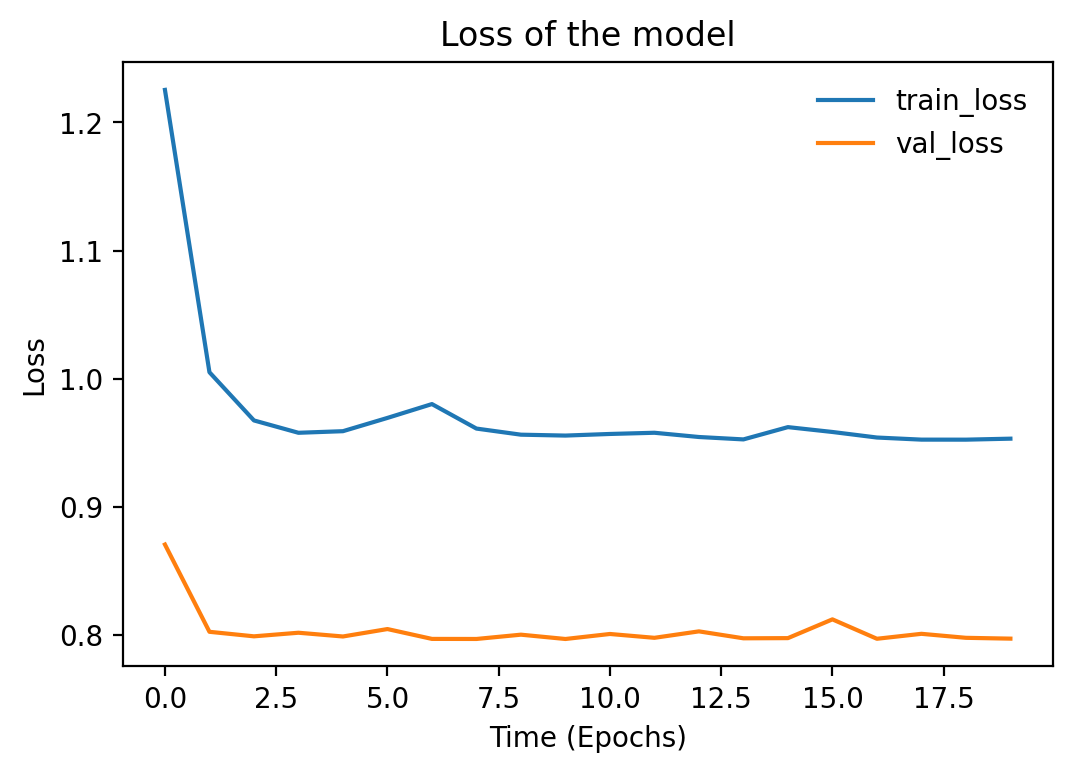

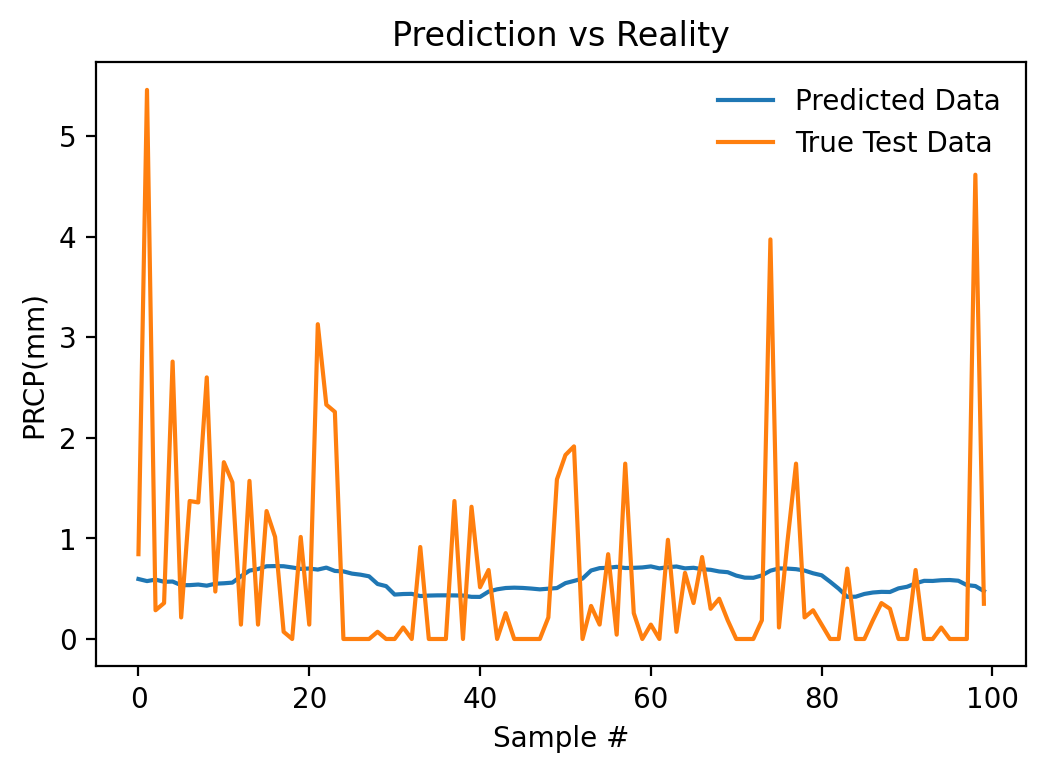

In [53]:
# Training and plotting

# Preparing data for training
train_data,train_label,val_data,val_label,test_data,test_label = tableformtotrainingform(tabulate933list[2],testvalues)

history6=model6.fit(train_data, train_label,epochs=20,batch_size=round( np.shape(train_data)[0]/12 ),verbose=1,validation_data=(val_data,val_label))
# Batchsize defined in this way to ensure it's a good number
# Not too little not too large

# Plot loss
fig,ax=plt.subplots()
ax.plot(history6.history['loss'], label='train_loss')
ax.plot(history6.history['val_loss'], label='val_loss')
plt.title("Loss of the model")
plt.xlabel("Time (Epochs)")
plt.ylabel("Loss")
ax.legend()    

# Plot predictions
test_predict=model6.predict(test_data)
fig,ax=plt.subplots()
ax.plot(test_predict,label="Predicted Data")
ax.plot(test_label,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample #")
ax.set_ylabel('PRCP(mm)')
ax.legend()

### Traning model over all variables

In [54]:
# Define model
model7=keras.models.Sequential()
model7.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model7.add(keras.layers.LSTM(50, activation='relu'))
model7.add(keras.layers.Dense(50,activation='relu'))
model7.add(keras.layers.Dense(50,activation='relu'))
model7.add(keras.layers.Dense(50,activation='relu'))
model7.add(keras.layers.Dense(1,activation="linear"))
model7.compile(loss='mean_squared_error',optimizer='adam')
model7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 8, 100)            40800     
                                                                 
 lstm_15 (LSTM)              (None, 50)                30200     
                                                                 
 dense_27 (Dense)            (None, 50)                2550      
                                                                 
 dense_28 (Dense)            (None, 50)                2550      
                                                                 
 dense_29 (Dense)            (None, 50)                2550      
                                                                 
 dense_30 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-trai

TMAX
Epoch 1/20
13/13 [==============================] - 5s 129ms/step - loss: 432.9020 - val_loss: 372.1874
Epoch 2/20
13/13 [==============================] - 1s 48ms/step - loss: 219.2939 - val_loss: 79.4762
Epoch 3/20
13/13 [==============================] - 1s 48ms/step - loss: 65.2975 - val_loss: 47.3908
Epoch 4/20
13/13 [==============================] - 1s 48ms/step - loss: 40.0723 - val_loss: 36.3402
Epoch 5/20
13/13 [==============================] - 1s 63ms/step - loss: 32.0400 - val_loss: 33.8753
Epoch 6/20
13/13 [==============================] - 1s 49ms/step - loss: 29.5476 - val_loss: 27.3656
Epoch 7/20
13/13 [==============================] - 1s 53ms/step - loss: 23.3464 - val_loss: 23.0146
Epoch 8/20
13/13 [==============================] - 1s 68ms/step - loss: 21.2779 - val_loss: 21.4948 0s - loss:
Epoch 9/20
13/13 [==============================] - 1s 50ms/step - loss: 20.4726 - val_loss: 21.4614
Epoch 10/20
13/13 [==============================] - 1s 52ms/step - los

12/12 [==============================] - 3s 120ms/step - loss: 464.4143 - val_loss: 721.8636
Epoch 2/20
12/12 [==============================] - 1s 61ms/step - loss: 447.7491 - val_loss: 708.5654
Epoch 3/20
12/12 [==============================] - 1s 62ms/step - loss: 443.4546 - val_loss: 717.6899
Epoch 4/20
12/12 [==============================] - 1s 66ms/step - loss: 438.9257 - val_loss: 707.9705
Epoch 5/20
12/12 [==============================] - 1s 67ms/step - loss: 436.0852 - val_loss: 703.5191
Epoch 6/20
12/12 [==============================] - 1s 51ms/step - loss: 433.0639 - val_loss: 702.6324
Epoch 7/20
12/12 [==============================] - 0s 41ms/step - loss: 431.9393 - val_loss: 699.9024
Epoch 8/20
12/12 [==============================] - 0s 40ms/step - loss: 426.0037 - val_loss: 719.7456
Epoch 9/20
12/12 [==============================] - 0s 40ms/step - loss: 431.7319 - val_loss: 704.2977
Epoch 10/20
12/12 [==============================] - 0s 41ms/step - loss: 420.4556 

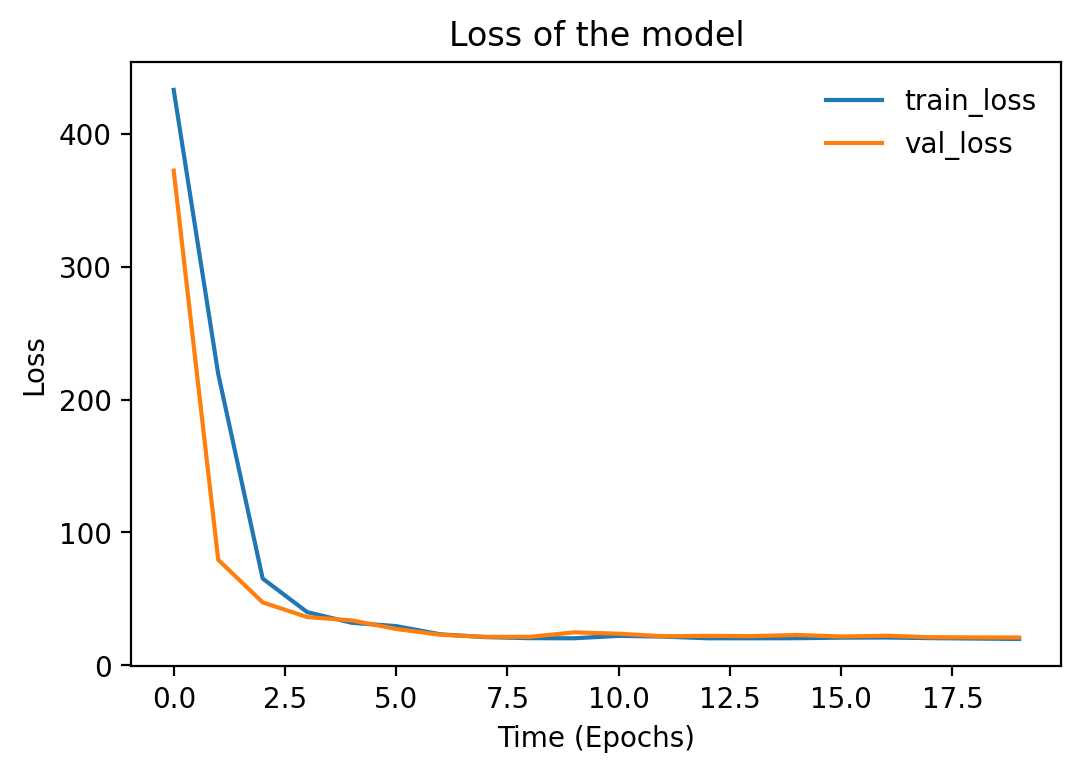

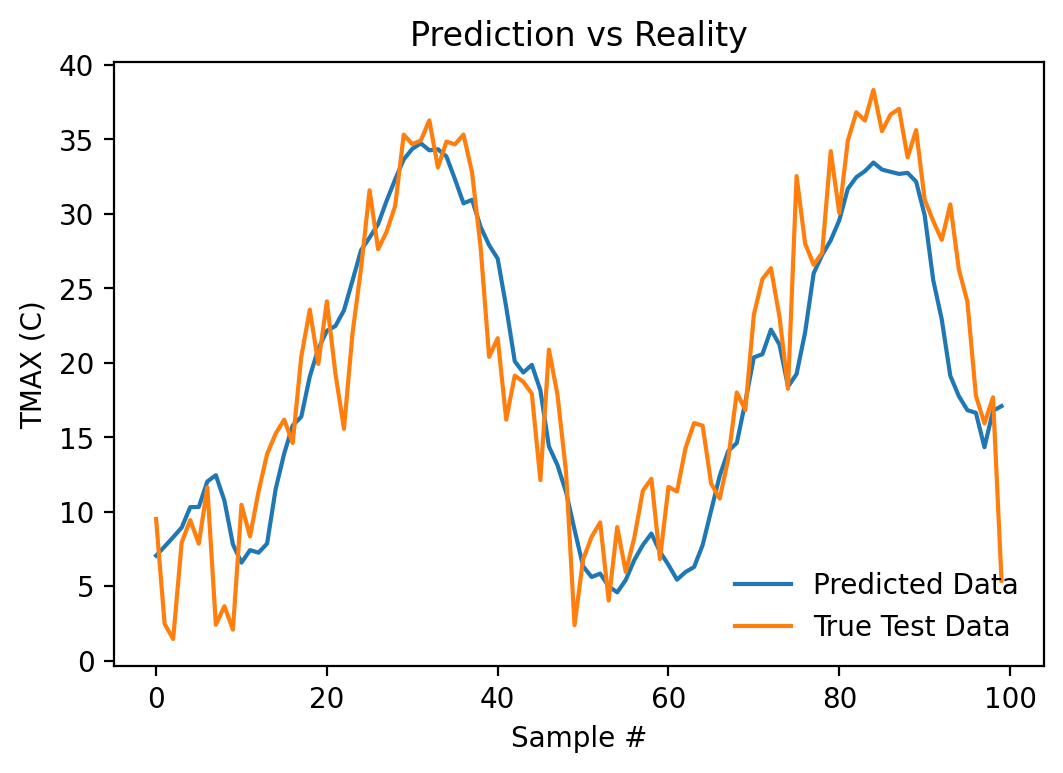

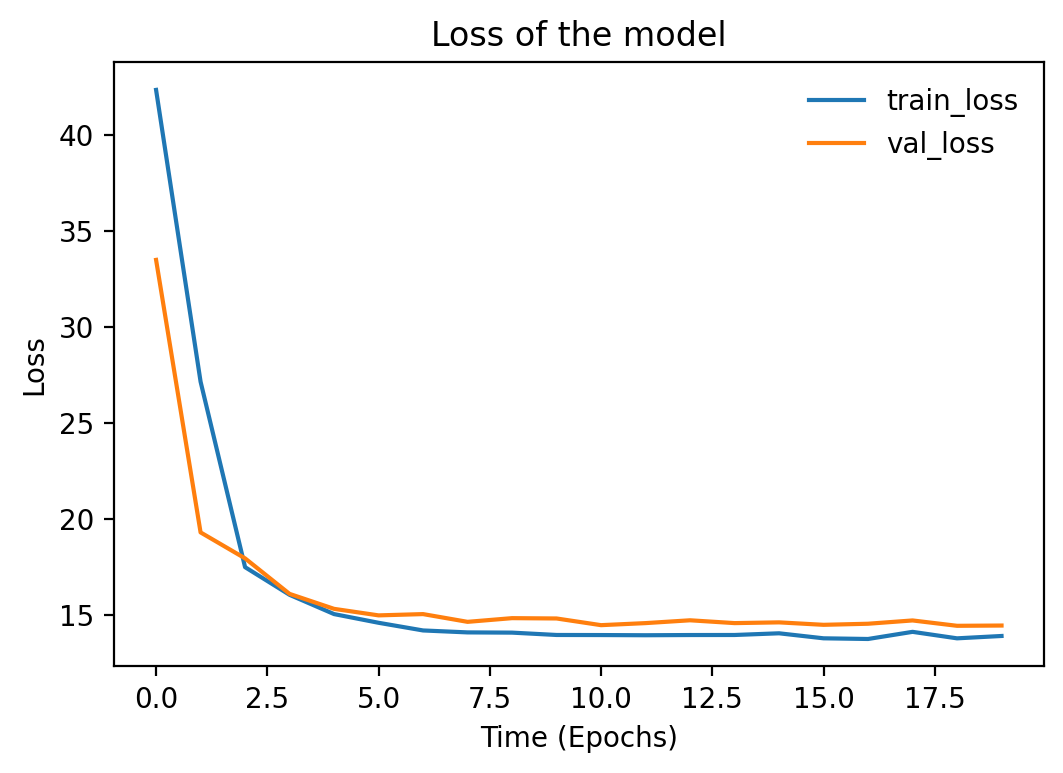

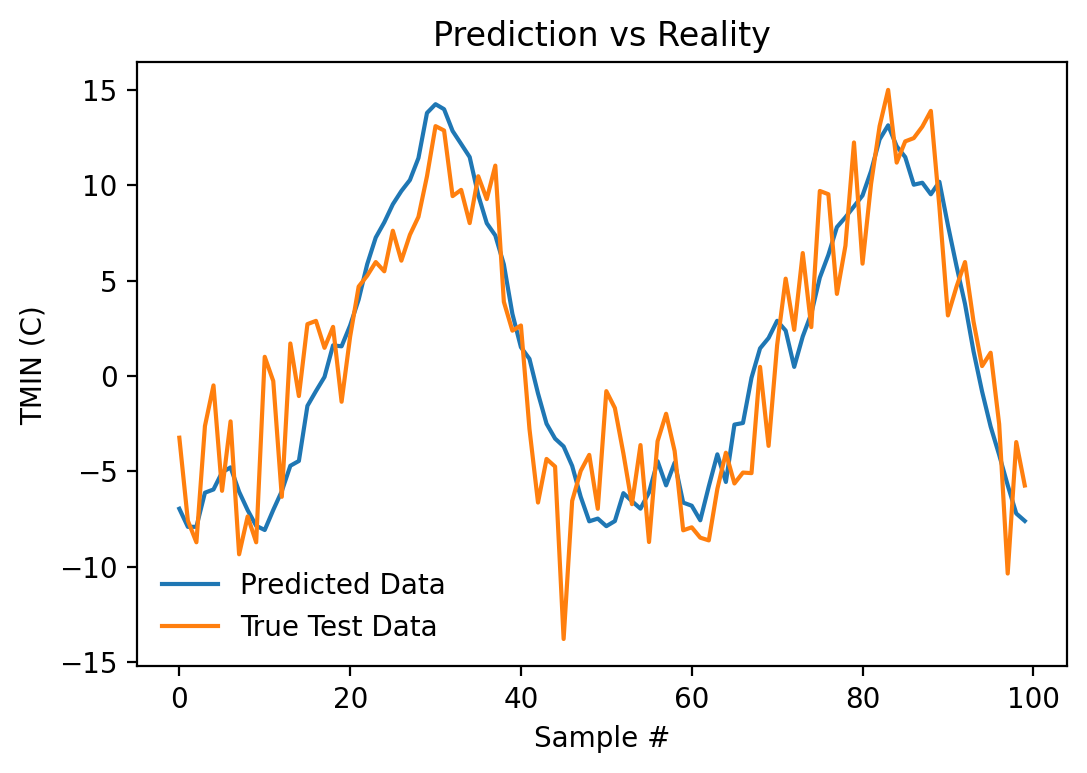

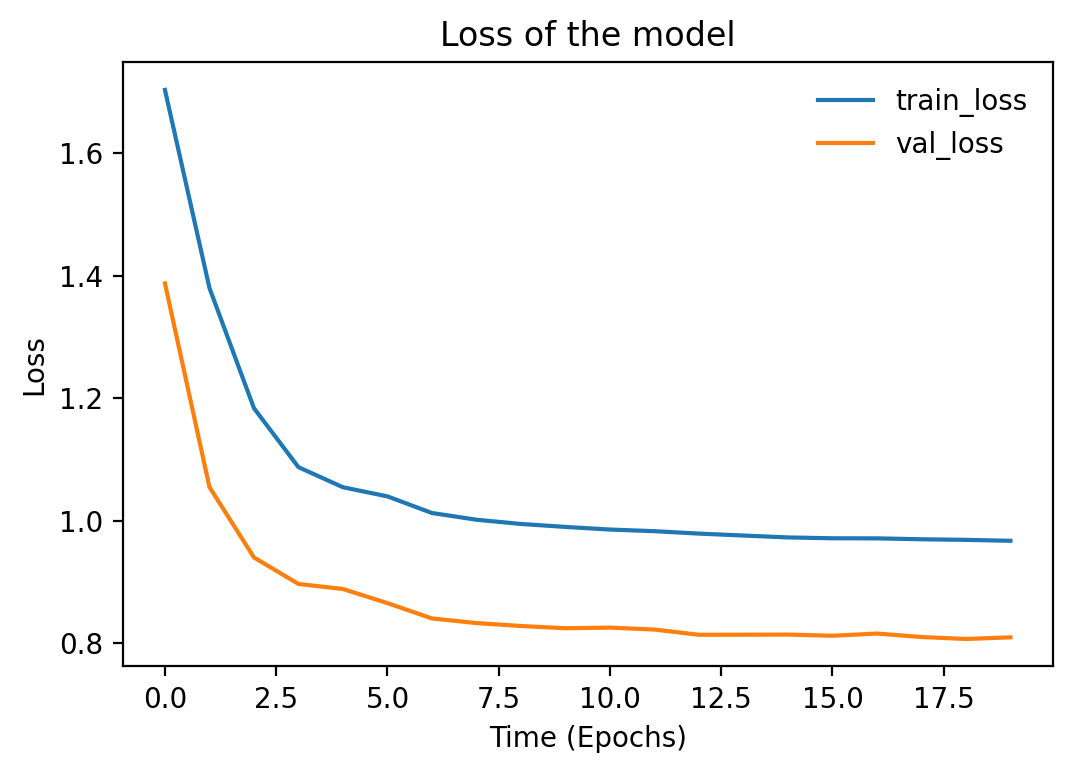

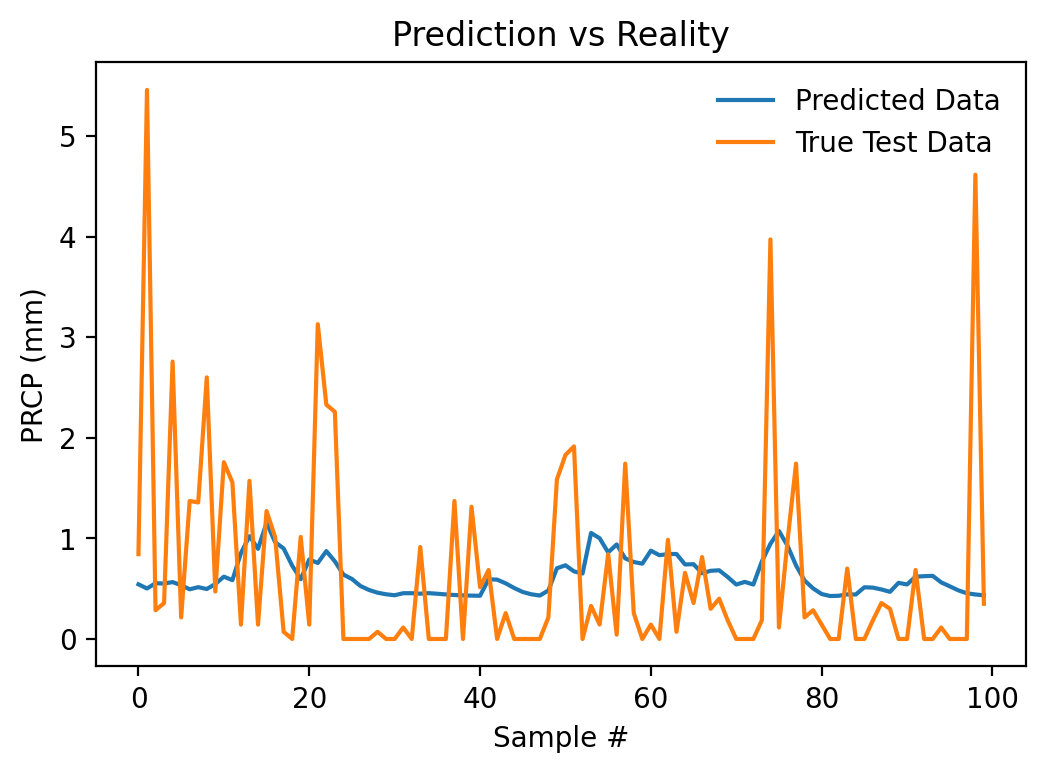

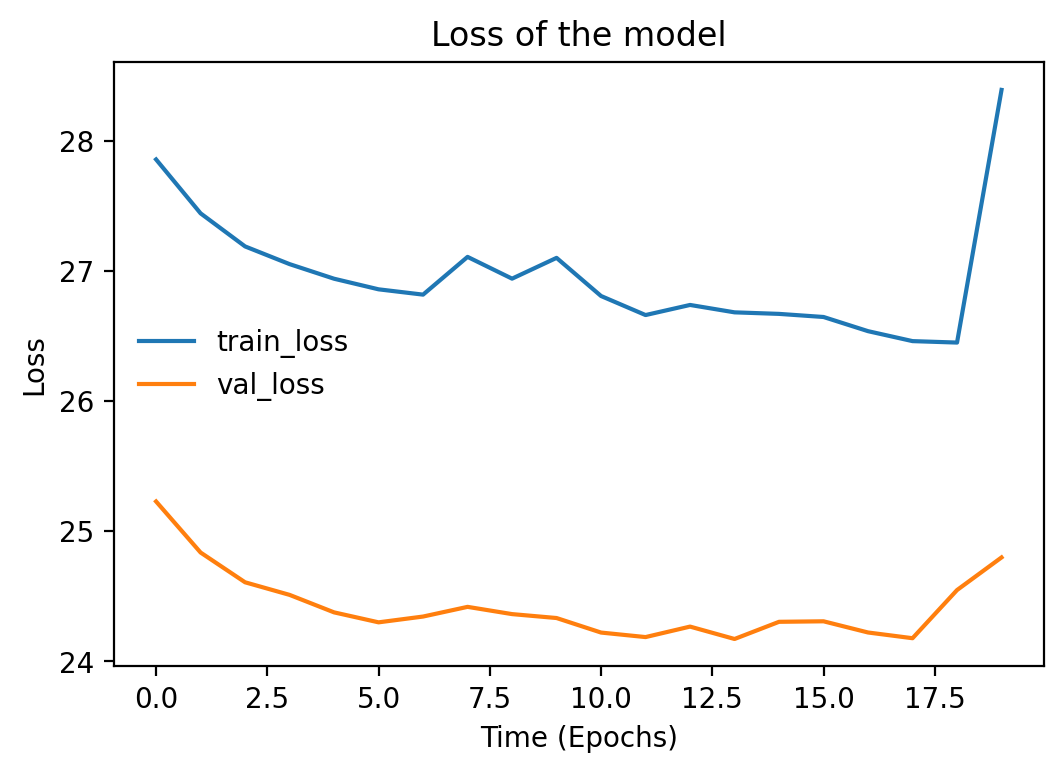

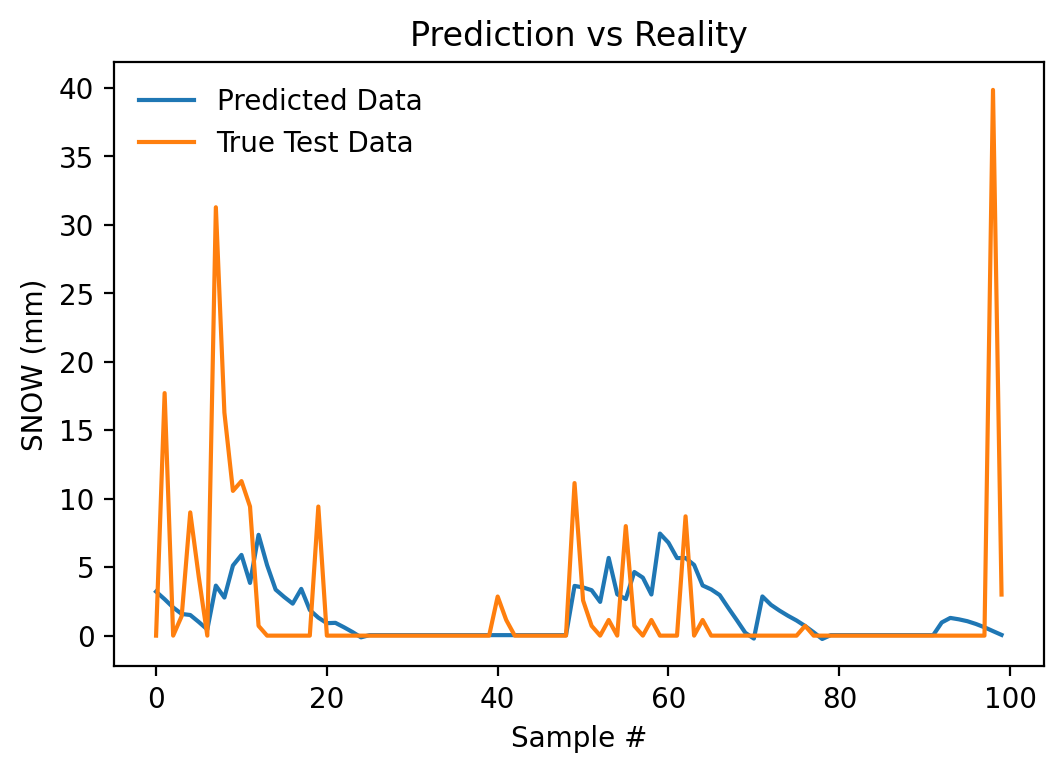

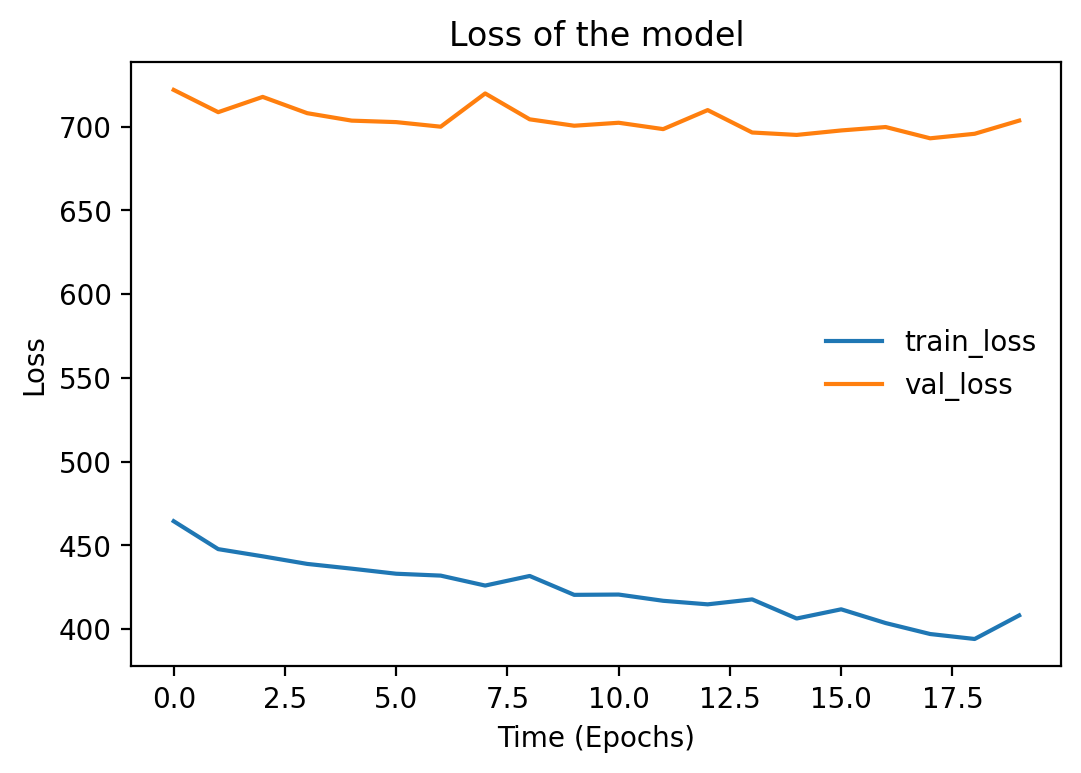

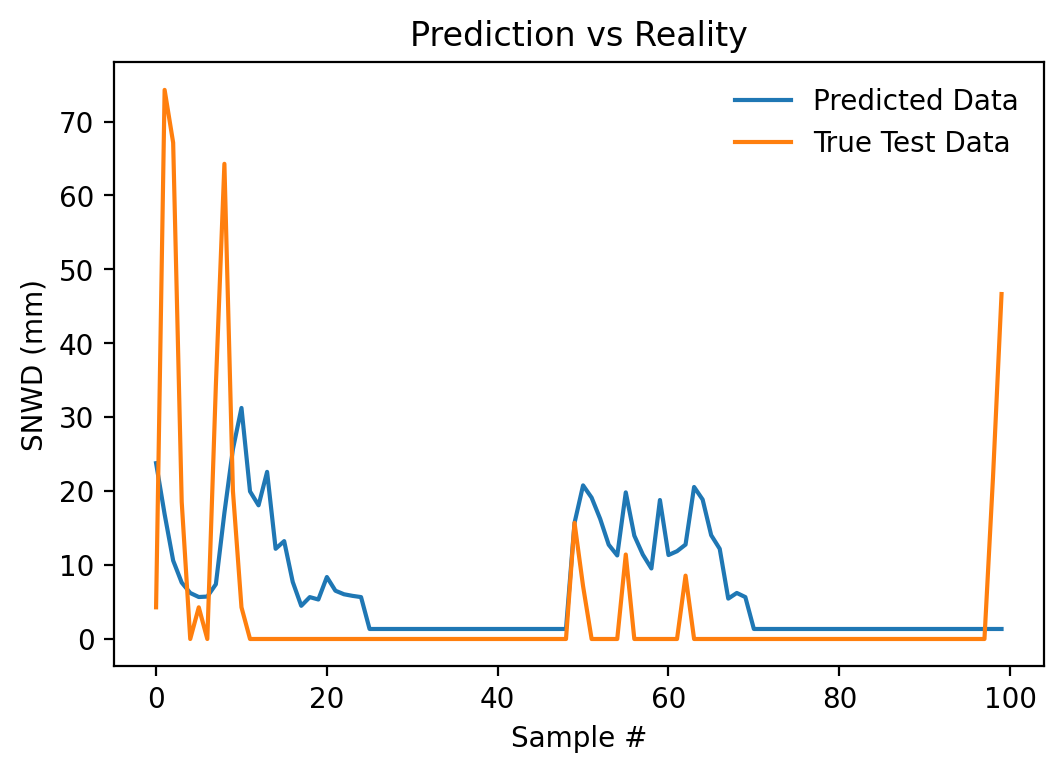

In [55]:
# Training and plotting

trainingconditionlist(tabulate933list,testvalues,dataframenames,model7,20,12,unitslist)

### Analysis

We can see that training the model only on PRCP to predict just a year in advance, rather than 10, still does not lead to significantly better predictions for PRCP, providing greater evidence that the order in which the model in trained in is insignificant.

Also, we can see the predictions for TMAX and TMIN also improve when only trying to predict a year in advance. I say this because this model predicts the fluctuations in the data fairly better. This indicates that training the model to predict just one year in advance is easier than training the model to predict 10 years in advance.

Also, the predictions for SNOW and SNWD are also arguably better however still not of good quality. 

Since we can observe that low quality predictions to PRCP,SNOW and SNWD are not likely due to be how ahead we're trying to predict and not due to the order of training of the model, I believe we can attribute the poor quality to the lack of pattern in the data for these variables.

# Loss functions

I wanted to determine the effects of the loss function on the training of the model and therefore decided to create different models which all have the same configuration but a different loss function [5]. I decided to '#' out the training and results as it just makes the notebook extremely long and ruins it's readibility. Nevertheless, the conclusion I arrive at is that the only other loss function suited for this task is the MAE loss function however it was observed that compiling the model with the mean squared error loss function leads to better results for the PRCP, SNOW and SNWD variables than when compiling it with the MAE loss function.


### Mean absolute error (MAE)


In [56]:
# Tabulate data

offset = 51
n_ts = 8
tabulate933list = tabulatelist(Data933list,offset,n_ts)

In [57]:
# Define model
model8=keras.models.Sequential()
model8.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model8.add(keras.layers.LSTM(50, activation='relu'))
model8.add(keras.layers.Dense(50,activation='relu'))
model8.add(keras.layers.Dense(50,activation='relu'))
model8.add(keras.layers.Dense(50,activation='relu'))
model8.add(keras.layers.Dense(1,activation="linear"))
model8.compile(loss='mean_absolute_error',optimizer='adam')
model8.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 8, 100)            40800     
                                                                 
 lstm_17 (LSTM)              (None, 50)                30200     
                                                                 
 dense_31 (Dense)            (None, 50)                2550      
                                                                 
 dense_32 (Dense)            (None, 50)                2550      
                                                                 
 dense_33 (Dense)            (None, 50)                2550      
                                                                 
 dense_34 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-trai

In [58]:
#trainingconditionlist(tabulate933list,testvalues,dataframenames,model8,20,12,unitslist)

### CosineSimilarity error function

In [59]:
#Define model
model9=keras.models.Sequential()
model9.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model9.add(keras.layers.LSTM(50, activation='relu'))
model9.add(keras.layers.Dense(50,activation='relu'))
model9.add(keras.layers.Dense(50,activation='relu'))
model9.add(keras.layers.Dense(50,activation='relu'))
model9.add(keras.layers.Dense(1,activation="linear"))
model9.compile(loss='cosine_similarity',optimizer='adam')
model9.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 8, 100)            40800     
                                                                 
 lstm_19 (LSTM)              (None, 50)                30200     
                                                                 
 dense_35 (Dense)            (None, 50)                2550      
                                                                 
 dense_36 (Dense)            (None, 50)                2550      
                                                                 
 dense_37 (Dense)            (None, 50)                2550      
                                                                 
 dense_38 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-trai

In [60]:
#trainingconditionlist(tabulate933list,testvalues,dataframenames,model9,20,12,unitslist)

### Mean Absolute Percentage Error

In [61]:
#Define model
model10=keras.models.Sequential()
model10.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model10.add(keras.layers.LSTM(50, activation='relu'))
model10.add(keras.layers.Dense(50,activation='relu'))
model10.add(keras.layers.Dense(50,activation='relu'))
model10.add(keras.layers.Dense(50,activation='relu'))
model10.add(keras.layers.Dense(1,activation="linear"))
model10.compile(loss='mean_absolute_percentage_error',optimizer='adam')
model10.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 8, 100)            40800     
                                                                 
 lstm_21 (LSTM)              (None, 50)                30200     
                                                                 
 dense_39 (Dense)            (None, 50)                2550      
                                                                 
 dense_40 (Dense)            (None, 50)                2550      
                                                                 
 dense_41 (Dense)            (None, 50)                2550      
                                                                 
 dense_42 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-tra

In [62]:
#trainingconditionlist(tabulate933list,testvalues,dataframenames,model10,20,12,unitslist)

### Mean Squared Logarithmic Error

In [63]:
#Define model
model11=keras.models.Sequential()
model11.add(keras.layers.LSTM(100,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
# Note how it's input_shape = (n_ts, features)
model11.add(keras.layers.LSTM(50, activation='relu'))
model11.add(keras.layers.Dense(50,activation='relu'))
model11.add(keras.layers.Dense(50,activation='relu'))
model11.add(keras.layers.Dense(50,activation='relu'))
model11.add(keras.layers.Dense(1,activation="linear"))
model11.compile(loss='mean_squared_logarithmic_error',optimizer='adam')
model11.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 8, 100)            40800     
                                                                 
 lstm_23 (LSTM)              (None, 50)                30200     
                                                                 
 dense_43 (Dense)            (None, 50)                2550      
                                                                 
 dense_44 (Dense)            (None, 50)                2550      
                                                                 
 dense_45 (Dense)            (None, 50)                2550      
                                                                 
 dense_46 (Dense)            (None, 1)                 51        
                                                                 
Total params: 78,701
Trainable params: 78,701
Non-tra

In [64]:
#trainingconditionlist(tabulate933list,testvalues,dataframenames,model11,20,12,unitslist)

# Bibliography

- [1] - Ryan, N. 2021. _"Week_6 pandas"_. \[Online\] UCL Moodle Resource. Available from https://moodle.ucl.ac.uk/course/view.php?id=6793 \[Accessed 9th January 2022\]
- [2] - Grepper. 2020. _"numpy 2d array to pandas data frame"_. \[Online\]. Available from: https://www.codegrepper.com/code-examples/python/numpy+2d+array+to+pandas+data+frame \[Accessed 9th January 2022\]
- [3] - pandas. 2022. _"pandas.Dataframe"_. \[Online\]. Available from: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html \[Accessed 9th January 2022\]
- [4] - 19076447. 2022. _"19076447 - GHCN Supplementary Notebook"_
- [5] - Keras. 2022. _"Losses"_. \[Online\]. Available from: https://keras.io/api/losses/ \[Accessed 9th January 2022\]
- [6] - stackoverflow. 2018. _"Pandas TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Indes'"_. \[Online\]. Available from: https://stackoverflow.com/questions/48272540/pandas-typeerror-only-valid-with-datetimeindex-timedeltaindex-or-periodindex \[Accessed 9th January 2022\]